# Claim2Title

This notebook looks at trying to implement the recursive model A described here - https://machinelearningmastery.com/encoder-decoder-models-text-summarization-keras/.

## Getting the Data

First we need a source of say ~ 10,000 titles and claims. We'll concentrate on G06 as crossing the streams of chemistry and computing results in some funky chimeras.

In [2]:
# imports
import os, pickle
from keras.preprocessing import text
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Get the claim 1 and classificationt text

PIK = "claim_and_title_50k.data"

if os.path.isfile(PIK):
    with open(PIK, "rb") as f:
        print("Loading data")
        data = pickle.load(f)
        print("{0} claims and titles loaded".format(len(data)))

Loading data
50000 claims and titles loaded


In [4]:
data[1]

('\n1. A method comprising:\nreceiving a first e-mail message;\ndetermining whether the received first e-mail message is related to another e-mail message in a mailbox;\nwhen, based on the determining, the first e-mail message is not related another e-mail message, displaying a first entry associated with the first e-mail message in a mailbox display; and\nwhen, based on the determining, the first e-mail message is related to a second e-mail message, generating an e-mail thread, the e-mail thread associating the first e-mail message and the second e-mail message, the e-mail thread having a thread header including information derived from attributes of at least one of the first or second e-mail messages, and displaying the thread header in the mailbox display as a thread header entry in place of separate mailbox entries for the first e-mail message and the second e-mail message.\n\n',
 '\tThreaded presentation of electronic mail\n')

## Look at Data

In [5]:
length = max([len(d[0]) for d in data])
print("Our longest claim is {0} characters long.".format(length))

Our longest claim is 17017 characters long.


In [6]:
length = max([len(d[1]) for d in data])
print("Our longest title is {0} characters long.".format(length))

Our longest title is 417 characters long.


### Preparing Titles

We will start with a limited vocabulary in words on both the input and output.

In [7]:
# Setting vocabulary lengths
X_vocab_len = 5000
y_vocab_len = 2500

In [8]:
# lower = true doesn't seem to work at the character level
# We were filtering out our \t and \n characters! - use words instead of \t and \n
print("\n\nAdding start and stop tokens to output")
data = [(c, "startseq {0} stopseq".format(t)) for c, t in data]

t_title = text.Tokenizer(num_words=y_vocab_len, lower=True)
Y_texts = [d[1] for d in data]
t_title.fit_on_texts(Y_texts)



Adding start and stop tokens to output


In [9]:
Y_texts[0:5]

['startseq \tOperating a storage server on a virtual machine\n stopseq',
 'startseq \tThreaded presentation of electronic mail\n stopseq',
 'startseq \tMethod and apparatus for communicating during automated data processing\n stopseq',
 'startseq \tTelemetry data analysis using multivariate sequential probability ratio test\n stopseq',
 'startseq \tMethod and a system for integrating data from a source to a destination\n stopseq']

In [10]:
print("Our output sequences (titles) have a vocabulary of {0} words".format(max([v for k, v in t_title.word_index.items()])))

Our output sequences (titles) have a vocabulary of 13465 words


So limiting to 2500 is fairly restrictive - about 1/5 of the total in just our small sample.

In [11]:
Y_seqs = t_title.texts_to_sequences(Y_texts)

In [12]:
Y_seqs[0]

[1, 115, 7, 27, 72, 25, 7, 48, 84, 2]

### Preparing Claims

In [13]:
t_claim = text.Tokenizer(
                num_words=X_vocab_len, 
                filters='1.:;\n',
                lower=True,
                split=" ",
                char_level=False
)
X_texts = [d[0] for d in data]
t_claim.fit_on_texts(X_texts)
X_seqs = t_claim.texts_to_sequences(X_texts)

In [14]:
print("Our input sequences (claims) have a vocabulary of {0} words".format(max([v for k, v in t_claim.word_index.items()])))


Our input sequences (claims) have a vocabulary of 69693 words


In [15]:
print(X_texts[0], X_seqs[0])


1. A virtualized clustered storage server system, comprising:
at least one host computer having a host operating system; and
a plurality of virtual computers operating on the at least one host computer, each of the plurality of virtual computers having one or more virtualization components and a guest operating system, said guest operating system being hosted by said host operating system of the at least one host computer,
wherein each virtual computer of the plurality of virtual computers comprises a storage server system instance, including said guest operating system and at least one facility including at least one simulated storage device for storing data of at least one virtual volume,
wherein the at least one host computer is to receive commands for manipulating data of a specified virtual volume, wherein each command is directed to a specified storage server system instance, and wherein the at least one host computer routes each of the commands to the respective specified stora

In [16]:
print(Y_texts[0], Y_seqs[0])

startseq 	Operating a storage server on a virtual machine
 stopseq [1, 115, 7, 27, 72, 25, 7, 48, 84, 2]


Let's have a look at our sequence length distributions.

Our longest sequence is 2386 tokens long.


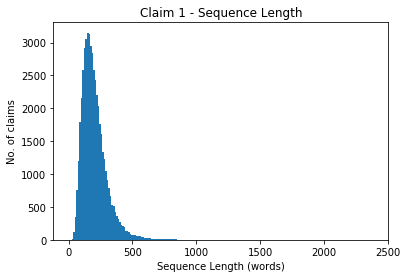

In [17]:
X_length = [len(x) for x in X_seqs]
max_length = max(X_length)
print("Our longest sequence is {0} tokens long.".format(max_length))

bins = np.linspace(0, max_length, 200)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims');
plt.xlabel('Sequence Length (words)');

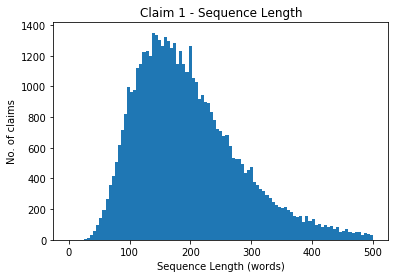

In [18]:
# Let's zoom in on 0 to 500
bins = np.linspace(0, 500, 100)
plt.hist(X_length, bins)
plt.title('Claim 1 - Sequence Length')
plt.ylabel('No. of claims');
plt.xlabel('Sequence Length (words)');

Let's limit our sequence length to 300 on our input.

Our longest sequence is 60 words long.


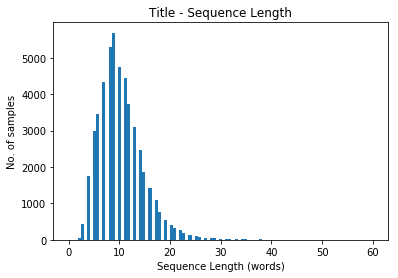

In [19]:
Y_length = [len(y) for y in Y_seqs]
max_y_length = max(Y_length)
print("Our longest sequence is {0} words long.".format(max_y_length))

bins = np.linspace(0, max_y_length, 100)
plt.hist(Y_length, bins)
plt.title('Title - Sequence Length')
plt.ylabel('No. of samples');
plt.xlabel('Sequence Length (words)');

Let's limit to 20 words on our output.  

So we can pad our input and output sequences, limiting to 300 on the input and 20 on the output.

In [20]:
# Setting maximum sequence lengths
X_max_len = 300
y_max_len = 20

In [27]:
# We want to reverse our X_seqs - so our preamble comes last and so is more influential
X = pad_sequences(X_seqs, maxlen=X_max_len, truncating='post')
# We don't want to reverse our output
Y = pad_sequences(Y_seqs, maxlen=y_max_len, padding='post', truncating='post')

In [28]:
print("Our X data has shape {0} and our Y data has shape {1}".format(X.shape, Y.shape))

Our X data has shape (50000, 300) and our Y data has shape (50000, 20)


In [29]:
print(X[0], Y[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    2 2573 3851   41   70   88   25   14   24    8  196   39   59
    2  196  182   34    5    2   22    3   97  968  182   18    1   14
   24    8  196  265   29    3    1   22    3   97  968   59    8   20
   30 2030  320    5    2 1521  182   88   16 1521  182   34   45 1802
   15   16  196  182   34    3    1   14   24    8  196  265   17   29
   97   39    3    1   22    3   97  968   73    2   41   70   34 2922
   53   16 1521  182   34    5   14   24    8 1317   53   14   24    8
 1452   41   28    9  105   10    3   14   24    8   97 1960   17    1
   14   24    8  196   39   13    4  155  700    9 3578   10    3    2
  294   97 1960   17   29  206   13 1190    4    2  294   41   70   34
 2922    5   17    1   14   24    8  196   39 3094   29    3    1  700
    4    1   93  294   41   70   34  417  167    2   97   81    3    1
    8   20   30 2030  320    3    1   97  265   17   29   41   70   34
  417 

## Building the Sequence to Sequence Model

We could maybe share the embedding layer as per here? https://stackoverflow.com/questions/42122168/keras-how-to-construct-a-shared-embedding-layer-for-each-input-neuron

The model by Oswaldo Ludwig shares the embedding layer. We can also look at using a pre-trained embedding layer.

See also here: http://www.orbifold.net/default/2017/01/10/embedding-and-tokenizer-in-keras/

In [30]:
from keras.layers import concatenate

# source text input model
inputs1 = Input(shape=(X_max_len,))
am1 = Embedding(X_vocab_len, 128)(inputs1)
am2 = LSTM(128)(am1)
# summary input model
inputs2 = Input(shape=(y_max_len,))
sm1 = Embedding(y_vocab_len, 128)(inputs2)
sm2 = LSTM(128)(sm1)
# decoder output model
decoder1 = concatenate([am2, sm2])
outputs = Dense(y_vocab_len, activation='softmax')(decoder1)
# tie it together [article, summary] [word]
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [31]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 128)     640000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 128)      320000      input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LS

To reduce the number of parameters we can probably share embeddings between the two inputs. But this would require a larger dense layer on the output.  

Because the one-hot vector takes a lot of memory we need to iterate the training in batches (as per here and other examples - https://github.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/blob/master/train_bot.py).

In [33]:
# We need to split into train and test data
from sklearn.model_selection import train_test_split

# seed for reproducing same results
seed = 9
np.random.seed(seed)

# split the data into training (80%) and testing (20%)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.2, random_state=seed)

In [34]:
# Basing training in sets code on here - https://github.com/ChunML/seq2seq/blob/master/seq2seq.py

BATCH_SIZE = 128 # Depends on GPU - most values are around this 32-128 
NB_EPOCH = 1
# Number of examples to group together in a set
NB_SET = 100

def find_checkpoint_file(folder):
    checkpoint_file = [f for f in os.listdir(folder) if 'kerascheckpoint' in f]
    if len(checkpoint_file) == 0:
        return []
    modified_time = [os.path.getmtime(f) for f in checkpoint_file]
    return checkpoint_file[np.argmax(modified_time)]

# Finding trained weights of previous epoch if any
saved_weights = find_checkpoint_file('.')

k_start = 1

# If any trained weight was found, then load them into the model
if len(saved_weights) != 0:
    print('[INFO] Saved weights found, loading...')
    epoch = saved_weights[saved_weights.rfind('_')+1:saved_weights.rfind('.')]
    model.load_weights(saved_weights)
    k_start = int(epoch) + 1

i_end = 0
num_examples = len(X_train)
# Initialise history of accuracy
acc = list()

# So instead of X we have [inputs1, inputs2] - this is where we need to fold in 
# - https://github.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/blob/master/train_bot.py

# So we have inputs2 that build up - we have a set of inputs2 up to the length of inputs2

for k in range(k_start, NB_EPOCH+1):
    # Shuffling the training data every epoch to avoid local minima
    indices = np.arange(num_examples)
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = Y_train[indices]

    # Training 100 sequences at a time
    for i in range(0, num_examples, NB_SET):
        if i + NB_SET >= num_examples:
            i_end = num_examples
        else:
            i_end = i + NB_SET
        
        set_size = (i_end-i)*y_max_len # e.g. 2000 for len = 20 and set = 100
        I_1_train = np.zeros((set_size, X_max_len))
        I_2_train = np.zeros((set_size, y_max_len))
        # This below is a big array
        Y_set_train = np.zeros((set_size, y_vocab_len))
        
        count = 0
        # Now we want to create, for each sample, a set of examples for each word in the title
        for l in range(0, (i_end - i)):
            # for each X and y in set of 100 
            
            # We need to build the input for the second encoder for the next word in y
            # I.e. for word 3 in the title the input2 consists of words 1 and 2 (using teacher forcing)
            
            # We only need to create examples up to the length of the title - but we can iterate up to
            # y_max_len for now
            for m in range(1, y_max_len):
                
                # Generate our one-hot y out
                one_hot_out = np.zeros((1, y_vocab_len))
                # This builds our one-hot generation into our training loop
                # The l and m respectively iterate through the samples and the output sequence elements
                one_hot_out[0, y_train[l][m]] = 1
                
                # Create a blank row/array for a partial input - this is fed into the decoder
                # It is of the same size as our title
                partial_input = np.zeros((1, y_max_len))
                # Because we are zero padding add words up to m to end - DOES THIS STILL WORK IF WE ZERO PAD
                # AT THE END? - Yes but we just feed the words with zeros first?
                partial_input[0, -m:] = y_train[l][0:m]
            
                # This fills in each sample of the training data, i.e. count increments up to set size
                I_1_train[count, :] = X_train[l]
                I_2_train[count, :] = partial_input
                Y_set_train[count, :] = one_hot_out
                count += 1
            
        print('[INFO] Training model: epoch {} - {}/{} samples'.format(k, i, num_examples))
        callback = model.fit([I_1_train, I_2_train], Y_set_train, batch_size=BATCH_SIZE, epochs=1)
        big_acc = acc + callback.history['acc']
        # Get history and apppend new data to running set here
    model.save_weights('kerascheckpoint_epoch_{}.hdf5'.format(k))

[INFO] Training model: epoch 1th 0/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 6.7545
[INFO] Training model: epoch 1th 100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 3.3911
[INFO] Training model: epoch 1th 200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 3.1002
[INFO] Training model: epoch 1th 300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 3.0144
[INFO] Training model: epoch 1th 400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.9499
[INFO] Training model: epoch 1th 500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.8704
[INFO] Training model: epoch 1th 600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.7579
[INFO] Training model: epoch 1th 700/40000 samples
Epoch 1/1
200

[INFO] Training model: epoch 1th 12100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1521
[INFO] Training model: epoch 1th 12200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1485
[INFO] Training model: epoch 1th 12300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1455
[INFO] Training model: epoch 1th 12400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1417
[INFO] Training model: epoch 1th 12500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1385
[INFO] Training model: epoch 1th 12600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1356
[INFO] Training model: epoch 1th 12700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1324
[INFO] Training model: epoch 1th 12800/40000 sam

2000/2000 [==============================] - 16s 8ms/step - loss: 0.0460
[INFO] Training model: epoch 1th 18200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0450
[INFO] Training model: epoch 1th 18300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0440
[INFO] Training model: epoch 1th 18400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0435
[INFO] Training model: epoch 1th 18500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0426
[INFO] Training model: epoch 1th 18600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0421
[INFO] Training model: epoch 1th 18700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0414
[INFO] Training model: epoch 1th 18800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s

2000/2000 [==============================] - 14s 7ms/step - loss: 0.0086
[INFO] Training model: epoch 1th 30200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0085
[INFO] Training model: epoch 1th 30300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0085
[INFO] Training model: epoch 1th 30400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0084
[INFO] Training model: epoch 1th 30500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0083
[INFO] Training model: epoch 1th 30600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0082
[INFO] Training model: epoch 1th 30700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0081
[INFO] Training model: epoch 1th 30800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s

2000/2000 [==============================] - 15s 7ms/step - loss: 0.1920
[INFO] Training model: epoch 2th 2200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1810
[INFO] Training model: epoch 2th 2300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1711
[INFO] Training model: epoch 2th 2400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1607
[INFO] Training model: epoch 2th 2500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1515
[INFO] Training model: epoch 2th 2600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1445
[INFO] Training model: epoch 2th 2700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1381
[INFO] Training model: epoch 2th 2800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/st

2000/2000 [==============================] - 15s 7ms/step - loss: 0.0491
[INFO] Training model: epoch 2th 8300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 18s 9ms/step - loss: 0.0488
[INFO] Training model: epoch 2th 8400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0485
[INFO] Training model: epoch 2th 8500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0483
[INFO] Training model: epoch 2th 8600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0479
[INFO] Training model: epoch 2th 8700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0476
[INFO] Training model: epoch 2th 8800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0473
[INFO] Training model: epoch 2th 8900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/st

2000/2000 [==============================] - 15s 8ms/step - loss: 0.0355
[INFO] Training model: epoch 2th 20300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0355
[INFO] Training model: epoch 2th 20400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0354
[INFO] Training model: epoch 2th 20500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0354
[INFO] Training model: epoch 2th 20600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0354
[INFO] Training model: epoch 2th 20700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0353
[INFO] Training model: epoch 2th 20800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0353
[INFO] Training model: epoch 2th 20900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s

2000/2000 [==============================] - 15s 7ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 32300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 32400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 32500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 32600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 32700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 32800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 32900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s

2000/2000 [==============================] - 16s 8ms/step - loss: 0.2328
[INFO] Training model: epoch 3th 4400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2315
[INFO] Training model: epoch 3th 4500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2307
[INFO] Training model: epoch 3th 4600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2296
[INFO] Training model: epoch 3th 4700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2288
[INFO] Training model: epoch 3th 4800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2279
[INFO] Training model: epoch 3th 4900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2272
[INFO] Training model: epoch 3th 5000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/st

2000/2000 [==============================] - 15s 7ms/step - loss: 0.2093
[INFO] Training model: epoch 3th 10500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2092
[INFO] Training model: epoch 3th 10600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2091
[INFO] Training model: epoch 3th 10700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2090
[INFO] Training model: epoch 3th 10800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2089
[INFO] Training model: epoch 3th 10900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2088
[INFO] Training model: epoch 3th 11000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2087
[INFO] Training model: epoch 3th 11100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s

2000/2000 [==============================] - 14s 7ms/step - loss: 0.2033
[INFO] Training model: epoch 3th 22500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2033
[INFO] Training model: epoch 3th 22600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2033
[INFO] Training model: epoch 3th 22700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2033
[INFO] Training model: epoch 3th 22800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2032
[INFO] Training model: epoch 3th 22900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2032
[INFO] Training model: epoch 3th 23000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2032
[INFO] Training model: epoch 3th 23100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s

2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s

2000/2000 [==============================] - 14s 7ms/step - loss: 0.5820
[INFO] Training model: epoch 4th 6600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5817
[INFO] Training model: epoch 4th 6700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5815
[INFO] Training model: epoch 4th 6800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5813
[INFO] Training model: epoch 4th 6900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5811
[INFO] Training model: epoch 4th 7000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5810
[INFO] Training model: epoch 4th 7100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5808
[INFO] Training model: epoch 4th 7200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/st

2000/2000 [==============================] - 16s 8ms/step - loss: 0.5740
[INFO] Training model: epoch 4th 18600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 18700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 18800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 18900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 19000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 19100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5738
[INFO] Training model: epoch 4th 19200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s

2000/2000 [==============================] - 15s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 30600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 30700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 30800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 30900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s

[INFO] Training model: epoch 5th 2600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7010
[INFO] Training model: epoch 5th 2700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6989
[INFO] Training model: epoch 5th 2800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6973
[INFO] Training model: epoch 5th 2900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6957
[INFO] Training model: epoch 5th 3000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6944
[INFO] Training model: epoch 5th 3100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6930
[INFO] Training model: epoch 5th 3200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6921
[INFO] Training model: epoch 5th 3300/40000 samples
Epo

2000/2000 [==============================] - 14s 7ms/step - loss: 0.6714
[INFO] Training model: epoch 5th 14700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6713
[INFO] Training model: epoch 5th 14800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6713
[INFO] Training model: epoch 5th 14900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6713
[INFO] Training model: epoch 5th 15000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6712
[INFO] Training model: epoch 5th 15100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6712
[INFO] Training model: epoch 5th 15200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6712
[INFO] Training model: epoch 5th 15300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s

2000/2000 [==============================] - 15s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 26700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 26800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 26900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s

2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 17s 9ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 39000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 39100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 39200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 39300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s

2000/2000 [==============================] - 15s 7ms/step - loss: 0.9613
[INFO] Training model: epoch 6th 4800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9611
[INFO] Training model: epoch 6th 4900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9608
[INFO] Training model: epoch 6th 5000/40000 samples
Epoch 1/1
1792/2000 [=========================>....] - ETA: 1s - loss: 0.9810

KeyboardInterrupt: 

If we get a low loss is it just memorising the provided claims and titles?

Can we introduce some validation data?

We probably need to shuffle the created data in each set. Problem is that our validation data will be reused with the next set. Unless we generate a set of validation data for a reserved portion of data?

Yes we can pass validation data via - `history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test))` 

I can use the test data I create above.

The model uses the last output of the LSTM not the hidden state. Is this okay?

Here is another model - https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/

Stopped at epoch 6 because it looks like it stuck in a minima - epoch 3 is the best

```
[INFO] Training model: epoch 1th 39900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 136s - loss: 0.1721   

[INFO] Training model: epoch 5th 39900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 133s - loss: 0.9014 
# Basing training in sets code on here - https://github.com/ChunML/seq2seq/blob/master/seq2seq.py

​

BATCH_SIZE = 128 # Depends on GPU - most values are around this 32-128 

NB_EPOCH = 1

# Number of examples to group together in a set

NB_SET = 100

​

def find_checkpoint_file(folder):

    checkpoint_file = [f for f in os.listdir(folder) if 'kerascheckpoint' in f]

    if len(checkpoint_file) == 0:

        return []

    modified_time = [os.path.getmtime(f) for f in checkpoint_file]

    return checkpoint_file[np.argmax(modified_time)]

​

# Finding trained weights of previous epoch if any

saved_weights = find_checkpoint_file('.')

​

k_start = 1

​

# If any trained weight was found, then load them into the model

if len(saved_weights) != 0:

    print('[INFO] Saved weights found, loading...')

    epoch = saved_weights[saved_weights.rfind('_')+1:saved_weights.rfind('.')]

    model.load_weights(saved_weights)

    k_start = int(epoch) + 1

​

i_end = 0

num_examples = len(X_train)

# Initialise history of accuracy

acc = list()

​

# So instead of X we have [inputs1, inputs2] - this is where we need to fold in 

# - https://github.com/oswaldoludwig/Seq2seq-Chatbot-for-Keras/blob/master/train_bot.py

​

# So we have inputs2 that build up - we have a set of inputs2 up to the length of inputs2

​

for k in range(k_start, NB_EPOCH+1):

    # Shuffling the training data every epoch to avoid local minima

    indices = np.arange(num_examples)

    np.random.shuffle(indices)

    X_train = X_train[indices]

    y_train = Y_train[indices]

​

    # Training 100 sequences at a time

    for i in range(0, num_examples, NB_SET):

        if i + NB_SET >= num_examples:

            i_end = num_examples

        else:

            i_end = i + NB_SET

        

        set_size = (i_end-i)*y_max_len # e.g. 2000 for len = 20 and set = 100

        I_1_train = np.zeros((set_size, X_max_len))

        I_2_train = np.zeros((set_size, y_max_len))

        # This below is a big array

        Y_set_train = np.zeros((set_size, y_vocab_len))

        

        count = 0

        # Now we want to create, for each sample, a set of examples for each word in the title

        for l in range(0, (i_end - i)):

            # for each X and y in set of 100 

            

            # We need to build the input for the second encoder for the next word in y

            # I.e. for word 3 in the title the input2 consists of words 1 and 2 (using teacher forcing)

            

            # We only need to create examples up to the length of the title - but we can iterate up to

            # y_max_len for now

            for m in range(1, y_max_len):

                

                # Generate our one-hot y out

                one_hot_out = np.zeros((1, y_vocab_len))

                # This builds our one-hot generation into our training loop

                # The l and m respectively iterate through the samples and the output sequence elements

                one_hot_out[0, y_train[l][m]] = 1

                

                # Create a blank row/array for a partial input - this is fed into the decoder

                # It is of the same size as our title

                partial_input = np.zeros((1, y_max_len))

                # Because we are zero padding add words up to m to end - DOES THIS STILL WORK IF WE ZERO PAD

                # AT THE END? - Yes but we just feed the words with zeros first?

                partial_input[0, -m:] = y_train[l][0:m]

            

                # This fills in each sample of the training data, i.e. count increments up to set size

                I_1_train[count, :] = X_train[l]

                I_2_train[count, :] = partial_input

                Y_set_train[count, :] = one_hot_out

                count += 1

            

        print('[INFO] Training model: epoch {} - {}/{} samples'.format(k, i, num_examples))

        callback = model.fit([I_1_train, I_2_train], Y_set_train, batch_size=BATCH_SIZE, epochs=1)

        big_acc = acc + callback.history['acc']

        # Get history and apppend new data to running set here

    model.save_weights('kerascheckpoint_epoch_{}.hdf5'.format(k))

[INFO] Training model: epoch 1th 0/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 6.7545
[INFO] Training model: epoch 1th 100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 3.3911
[INFO] Training model: epoch 1th 200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 3.1002
[INFO] Training model: epoch 1th 300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 3.0144
[INFO] Training model: epoch 1th 400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.9499
[INFO] Training model: epoch 1th 500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.8704
[INFO] Training model: epoch 1th 600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.7579
[INFO] Training model: epoch 1th 700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.6246
[INFO] Training model: epoch 1th 800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.5086
[INFO] Training model: epoch 1th 900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.4338
[INFO] Training model: epoch 1th 1000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.3895
[INFO] Training model: epoch 1th 1100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.3620
[INFO] Training model: epoch 1th 1200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.3386
[INFO] Training model: epoch 1th 1300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.3133
[INFO] Training model: epoch 1th 1400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.2910
[INFO] Training model: epoch 1th 1500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 2.2637
[INFO] Training model: epoch 1th 1600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.2320
[INFO] Training model: epoch 1th 1700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.1966
[INFO] Training model: epoch 1th 1800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.1643
[INFO] Training model: epoch 1th 1900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.1287
[INFO] Training model: epoch 1th 2000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.0962
[INFO] Training model: epoch 1th 2100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.0629
[INFO] Training model: epoch 1th 2200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.0297
[INFO] Training model: epoch 1th 2300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.0008
[INFO] Training model: epoch 1th 2400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.9688
[INFO] Training model: epoch 1th 2500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.9382
[INFO] Training model: epoch 1th 2600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.9096
[INFO] Training model: epoch 1th 2700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.8800
[INFO] Training model: epoch 1th 2800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.8485
[INFO] Training model: epoch 1th 2900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.8213
[INFO] Training model: epoch 1th 3000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.7916
[INFO] Training model: epoch 1th 3100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.7648
[INFO] Training model: epoch 1th 3200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.7375
[INFO] Training model: epoch 1th 3300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 1.7070
[INFO] Training model: epoch 1th 3400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.6786
[INFO] Training model: epoch 1th 3500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.6553
[INFO] Training model: epoch 1th 3600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.6243
[INFO] Training model: epoch 1th 3700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.5973
[INFO] Training model: epoch 1th 3800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.5662
[INFO] Training model: epoch 1th 3900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.5398
[INFO] Training model: epoch 1th 4000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.5074
[INFO] Training model: epoch 1th 4100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 1.4776
[INFO] Training model: epoch 1th 4200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 1.4469
[INFO] Training model: epoch 1th 4300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.4144
[INFO] Training model: epoch 1th 4400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.3827
[INFO] Training model: epoch 1th 4500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.3515
[INFO] Training model: epoch 1th 4600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.3213
[INFO] Training model: epoch 1th 4700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.2865
[INFO] Training model: epoch 1th 4800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.2569
[INFO] Training model: epoch 1th 4900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.2243
[INFO] Training model: epoch 1th 5000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.1942
[INFO] Training model: epoch 1th 5100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 1.1615
[INFO] Training model: epoch 1th 5200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.1316
[INFO] Training model: epoch 1th 5300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.1022
[INFO] Training model: epoch 1th 5400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.0701
[INFO] Training model: epoch 1th 5500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.0401
[INFO] Training model: epoch 1th 5600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.0085
[INFO] Training model: epoch 1th 5700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9800
[INFO] Training model: epoch 1th 5800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9521
[INFO] Training model: epoch 1th 5900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9232
[INFO] Training model: epoch 1th 6000/40000 samples
Epoch 1/1

2000/2000 [==============================] - 16s 8ms/step - loss: 0.8933
[INFO] Training model: epoch 1th 6100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.8655
[INFO] Training model: epoch 1th 6200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.8398
[INFO] Training model: epoch 1th 6300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.8130
[INFO] Training model: epoch 1th 6400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.7876
[INFO] Training model: epoch 1th 6500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.7625
[INFO] Training model: epoch 1th 6600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7380
[INFO] Training model: epoch 1th 6700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.7153
[INFO] Training model: epoch 1th 6800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6896
[INFO] Training model: epoch 1th 6900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6681
[INFO] Training model: epoch 1th 7000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6473
[INFO] Training model: epoch 1th 7100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6243
[INFO] Training model: epoch 1th 7200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6047
[INFO] Training model: epoch 1th 7300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5855
[INFO] Training model: epoch 1th 7400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5670
[INFO] Training model: epoch 1th 7500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5478
[INFO] Training model: epoch 1th 7600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5296
[INFO] Training model: epoch 1th 7700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5129
[INFO] Training model: epoch 1th 7800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4964
[INFO] Training model: epoch 1th 7900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.4810
[INFO] Training model: epoch 1th 8000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.4655
[INFO] Training model: epoch 1th 8100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4547
[INFO] Training model: epoch 1th 8200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.4478
[INFO] Training model: epoch 1th 8300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.4263
[INFO] Training model: epoch 1th 8400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.4103
[INFO] Training model: epoch 1th 8500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.3970
[INFO] Training model: epoch 1th 8600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.3852
[INFO] Training model: epoch 1th 8700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.3725
[INFO] Training model: epoch 1th 8800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.3627
[INFO] Training model: epoch 1th 8900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.3511
[INFO] Training model: epoch 1th 9000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.3406
[INFO] Training model: epoch 1th 9100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3303
[INFO] Training model: epoch 1th 9200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3213
[INFO] Training model: epoch 1th 9300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3121
[INFO] Training model: epoch 1th 9400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3047
[INFO] Training model: epoch 1th 9500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2955
[INFO] Training model: epoch 1th 9600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2868
[INFO] Training model: epoch 1th 9700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2780
[INFO] Training model: epoch 1th 9800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2715
[INFO] Training model: epoch 1th 9900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2639
[INFO] Training model: epoch 1th 10000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2565
[INFO] Training model: epoch 1th 10100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2506
[INFO] Training model: epoch 1th 10200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2431
[INFO] Training model: epoch 1th 10300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2360
[INFO] Training model: epoch 1th 10400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2303
[INFO] Training model: epoch 1th 10500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2242
[INFO] Training model: epoch 1th 10600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2184
[INFO] Training model: epoch 1th 10700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2138
[INFO] Training model: epoch 1th 10800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2077
[INFO] Training model: epoch 1th 10900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2017
[INFO] Training model: epoch 1th 11000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1966
[INFO] Training model: epoch 1th 11100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1928
[INFO] Training model: epoch 1th 11200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1882
[INFO] Training model: epoch 1th 11300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1840
[INFO] Training model: epoch 1th 11400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1793
[INFO] Training model: epoch 1th 11500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1750
[INFO] Training model: epoch 1th 11600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1712
[INFO] Training model: epoch 1th 11700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1656
[INFO] Training model: epoch 1th 11800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1626
[INFO] Training model: epoch 1th 11900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1587
[INFO] Training model: epoch 1th 12000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1552

[INFO] Training model: epoch 1th 12100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1521
[INFO] Training model: epoch 1th 12200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1485
[INFO] Training model: epoch 1th 12300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1455
[INFO] Training model: epoch 1th 12400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1417
[INFO] Training model: epoch 1th 12500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1385
[INFO] Training model: epoch 1th 12600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1356
[INFO] Training model: epoch 1th 12700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1324
[INFO] Training model: epoch 1th 12800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1298
[INFO] Training model: epoch 1th 12900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1263
[INFO] Training model: epoch 1th 13000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1249
[INFO] Training model: epoch 1th 13100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1215
[INFO] Training model: epoch 1th 13200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1191
[INFO] Training model: epoch 1th 13300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1169
[INFO] Training model: epoch 1th 13400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1146
[INFO] Training model: epoch 1th 13500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1117
[INFO] Training model: epoch 1th 13600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1092
[INFO] Training model: epoch 1th 13700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1066
[INFO] Training model: epoch 1th 13800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1046
[INFO] Training model: epoch 1th 13900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1021
[INFO] Training model: epoch 1th 14000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1000
[INFO] Training model: epoch 1th 14100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0983
[INFO] Training model: epoch 1th 14200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0963
[INFO] Training model: epoch 1th 14300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0942
[INFO] Training model: epoch 1th 14400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0926
[INFO] Training model: epoch 1th 14500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0907
[INFO] Training model: epoch 1th 14600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0889
[INFO] Training model: epoch 1th 14700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0870
[INFO] Training model: epoch 1th 14800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0854
[INFO] Training model: epoch 1th 14900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0838
[INFO] Training model: epoch 1th 15000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0817
[INFO] Training model: epoch 1th 15100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0808
[INFO] Training model: epoch 1th 15200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0790
[INFO] Training model: epoch 1th 15300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0774
[INFO] Training model: epoch 1th 15400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0759
[INFO] Training model: epoch 1th 15500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0742
[INFO] Training model: epoch 1th 15600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0729
[INFO] Training model: epoch 1th 15700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0712
[INFO] Training model: epoch 1th 15800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0699
[INFO] Training model: epoch 1th 15900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0684
[INFO] Training model: epoch 1th 16000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0672
[INFO] Training model: epoch 1th 16100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0662
[INFO] Training model: epoch 1th 16200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0647
[INFO] Training model: epoch 1th 16300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0634
[INFO] Training model: epoch 1th 16400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0624
[INFO] Training model: epoch 1th 16500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0613
[INFO] Training model: epoch 1th 16600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0600
[INFO] Training model: epoch 1th 16700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0592
[INFO] Training model: epoch 1th 16800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0578
[INFO] Training model: epoch 1th 16900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0569
[INFO] Training model: epoch 1th 17000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0559
[INFO] Training model: epoch 1th 17100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0549
[INFO] Training model: epoch 1th 17200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0541
[INFO] Training model: epoch 1th 17300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0531
[INFO] Training model: epoch 1th 17400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0517
[INFO] Training model: epoch 1th 17500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0508
[INFO] Training model: epoch 1th 17600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0498
[INFO] Training model: epoch 1th 17700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0491
[INFO] Training model: epoch 1th 17800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0483
[INFO] Training model: epoch 1th 17900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0474
[INFO] Training model: epoch 1th 18000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0465
[INFO] Training model: epoch 1th 18100/40000 samples
Epoch 1/1

2000/2000 [==============================] - 16s 8ms/step - loss: 0.0460
[INFO] Training model: epoch 1th 18200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0450
[INFO] Training model: epoch 1th 18300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0440
[INFO] Training model: epoch 1th 18400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0435
[INFO] Training model: epoch 1th 18500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0426
[INFO] Training model: epoch 1th 18600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0421
[INFO] Training model: epoch 1th 18700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0414
[INFO] Training model: epoch 1th 18800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0405
[INFO] Training model: epoch 1th 18900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0401
[INFO] Training model: epoch 1th 19000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0392
[INFO] Training model: epoch 1th 19100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0385
[INFO] Training model: epoch 1th 19200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0378
[INFO] Training model: epoch 1th 19300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0372
[INFO] Training model: epoch 1th 19400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0366
[INFO] Training model: epoch 1th 19500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0360
[INFO] Training model: epoch 1th 19600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0354
[INFO] Training model: epoch 1th 19700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0349
[INFO] Training model: epoch 1th 19800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0344
[INFO] Training model: epoch 1th 19900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0337
[INFO] Training model: epoch 1th 20000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0333
[INFO] Training model: epoch 1th 20100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0327
[INFO] Training model: epoch 1th 20200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0323
[INFO] Training model: epoch 1th 20300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0317
[INFO] Training model: epoch 1th 20400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0311
[INFO] Training model: epoch 1th 20500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0307
[INFO] Training model: epoch 1th 20600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0304
[INFO] Training model: epoch 1th 20700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0298
[INFO] Training model: epoch 1th 20800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0293
[INFO] Training model: epoch 1th 20900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0288
[INFO] Training model: epoch 1th 21000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0286
[INFO] Training model: epoch 1th 21100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0281
[INFO] Training model: epoch 1th 21200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0274
[INFO] Training model: epoch 1th 21300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0270
[INFO] Training model: epoch 1th 21400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0267
[INFO] Training model: epoch 1th 21500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0262
[INFO] Training model: epoch 1th 21600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0259
[INFO] Training model: epoch 1th 21700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0255
[INFO] Training model: epoch 1th 21800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0252
[INFO] Training model: epoch 1th 21900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0248
[INFO] Training model: epoch 1th 22000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0245
[INFO] Training model: epoch 1th 22100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0240
[INFO] Training model: epoch 1th 22200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0236
[INFO] Training model: epoch 1th 22300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0233
[INFO] Training model: epoch 1th 22400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0230
[INFO] Training model: epoch 1th 22500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0228
[INFO] Training model: epoch 1th 22600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0222
[INFO] Training model: epoch 1th 22700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0220
[INFO] Training model: epoch 1th 22800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0218
[INFO] Training model: epoch 1th 22900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0214
[INFO] Training model: epoch 1th 23000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0210
[INFO] Training model: epoch 1th 23100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0208
[INFO] Training model: epoch 1th 23200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0205
[INFO] Training model: epoch 1th 23300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0203
[INFO] Training model: epoch 1th 23400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0200
[INFO] Training model: epoch 1th 23500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0197
[INFO] Training model: epoch 1th 23600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0194
[INFO] Training model: epoch 1th 23700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0191
[INFO] Training model: epoch 1th 23800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0188
[INFO] Training model: epoch 1th 23900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0186
[INFO] Training model: epoch 1th 24000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0183
[INFO] Training model: epoch 1th 24100/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 8ms/step - loss: 0.0181
[INFO] Training model: epoch 1th 24200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0178
[INFO] Training model: epoch 1th 24300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0176
[INFO] Training model: epoch 1th 24400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0173
[INFO] Training model: epoch 1th 24500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0171
[INFO] Training model: epoch 1th 24600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0169
[INFO] Training model: epoch 1th 24700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0167
[INFO] Training model: epoch 1th 24800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0164
[INFO] Training model: epoch 1th 24900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0162
[INFO] Training model: epoch 1th 25000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0160
[INFO] Training model: epoch 1th 25100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0158
[INFO] Training model: epoch 1th 25200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0156
[INFO] Training model: epoch 1th 25300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0154
[INFO] Training model: epoch 1th 25400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0153
[INFO] Training model: epoch 1th 25500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0150
[INFO] Training model: epoch 1th 25600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0148
[INFO] Training model: epoch 1th 25700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0147
[INFO] Training model: epoch 1th 25800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0145
[INFO] Training model: epoch 1th 25900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0143
[INFO] Training model: epoch 1th 26000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0140
[INFO] Training model: epoch 1th 26100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0140
[INFO] Training model: epoch 1th 26200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0137
[INFO] Training model: epoch 1th 26300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0136
[INFO] Training model: epoch 1th 26400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0134
[INFO] Training model: epoch 1th 26500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0132
[INFO] Training model: epoch 1th 26600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0130
[INFO] Training model: epoch 1th 26700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0129
[INFO] Training model: epoch 1th 26800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0127
[INFO] Training model: epoch 1th 26900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0126
[INFO] Training model: epoch 1th 27000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0124
[INFO] Training model: epoch 1th 27100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0123
[INFO] Training model: epoch 1th 27200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0122
[INFO] Training model: epoch 1th 27300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0120
[INFO] Training model: epoch 1th 27400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0119
[INFO] Training model: epoch 1th 27500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0117
[INFO] Training model: epoch 1th 27600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0115
[INFO] Training model: epoch 1th 27700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0114
[INFO] Training model: epoch 1th 27800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0113
[INFO] Training model: epoch 1th 27900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0111
[INFO] Training model: epoch 1th 28000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0110
[INFO] Training model: epoch 1th 28100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0109
[INFO] Training model: epoch 1th 28200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0108
[INFO] Training model: epoch 1th 28300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0106
[INFO] Training model: epoch 1th 28400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0105
[INFO] Training model: epoch 1th 28500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0104
[INFO] Training model: epoch 1th 28600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0103
[INFO] Training model: epoch 1th 28700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0101
[INFO] Training model: epoch 1th 28800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0100
[INFO] Training model: epoch 1th 28900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0099
[INFO] Training model: epoch 1th 29000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0098
[INFO] Training model: epoch 1th 29100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0097
[INFO] Training model: epoch 1th 29200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0096
[INFO] Training model: epoch 1th 29300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0095
[INFO] Training model: epoch 1th 29400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0094
[INFO] Training model: epoch 1th 29500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0093
[INFO] Training model: epoch 1th 29600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0091
[INFO] Training model: epoch 1th 29700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0091
[INFO] Training model: epoch 1th 29800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0089
[INFO] Training model: epoch 1th 29900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0089
[INFO] Training model: epoch 1th 30000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0087
[INFO] Training model: epoch 1th 30100/40000 samples
Epoch 1/1

2000/2000 [==============================] - 14s 7ms/step - loss: 0.0086
[INFO] Training model: epoch 1th 30200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0085
[INFO] Training model: epoch 1th 30300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0085
[INFO] Training model: epoch 1th 30400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0084
[INFO] Training model: epoch 1th 30500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0083
[INFO] Training model: epoch 1th 30600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0082
[INFO] Training model: epoch 1th 30700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0081
[INFO] Training model: epoch 1th 30800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0080
[INFO] Training model: epoch 1th 30900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0079
[INFO] Training model: epoch 1th 31000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0078
[INFO] Training model: epoch 1th 31100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0077
[INFO] Training model: epoch 1th 31200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0076
[INFO] Training model: epoch 1th 31300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0076
[INFO] Training model: epoch 1th 31400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0075
[INFO] Training model: epoch 1th 31500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0074
[INFO] Training model: epoch 1th 31600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0073
[INFO] Training model: epoch 1th 31700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0072
[INFO] Training model: epoch 1th 31800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0072
[INFO] Training model: epoch 1th 31900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0071
[INFO] Training model: epoch 1th 32000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0070
[INFO] Training model: epoch 1th 32100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0069
[INFO] Training model: epoch 1th 32200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0069
[INFO] Training model: epoch 1th 32300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0068
[INFO] Training model: epoch 1th 32400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0067
[INFO] Training model: epoch 1th 32500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0067
[INFO] Training model: epoch 1th 32600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0066
[INFO] Training model: epoch 1th 32700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0065
[INFO] Training model: epoch 1th 32800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0064
[INFO] Training model: epoch 1th 32900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0064
[INFO] Training model: epoch 1th 33000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0063
[INFO] Training model: epoch 1th 33100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0062
[INFO] Training model: epoch 1th 33200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0062
[INFO] Training model: epoch 1th 33300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0061
[INFO] Training model: epoch 1th 33400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0060
[INFO] Training model: epoch 1th 33500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0060
[INFO] Training model: epoch 1th 33600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0059
[INFO] Training model: epoch 1th 33700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0059
[INFO] Training model: epoch 1th 33800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0058
[INFO] Training model: epoch 1th 33900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0057
[INFO] Training model: epoch 1th 34000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0057
[INFO] Training model: epoch 1th 34100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0056
[INFO] Training model: epoch 1th 34200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0056
[INFO] Training model: epoch 1th 34300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0055
[INFO] Training model: epoch 1th 34400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0055
[INFO] Training model: epoch 1th 34500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0054
[INFO] Training model: epoch 1th 34600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0053
[INFO] Training model: epoch 1th 34700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0053
[INFO] Training model: epoch 1th 34800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0052
[INFO] Training model: epoch 1th 34900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0052
[INFO] Training model: epoch 1th 35000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0051
[INFO] Training model: epoch 1th 35100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0051
[INFO] Training model: epoch 1th 35200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0050
[INFO] Training model: epoch 1th 35300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0050
[INFO] Training model: epoch 1th 35400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0049
[INFO] Training model: epoch 1th 35500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0049
[INFO] Training model: epoch 1th 35600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0048
[INFO] Training model: epoch 1th 35700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0048
[INFO] Training model: epoch 1th 35800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0047
[INFO] Training model: epoch 1th 35900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0047
[INFO] Training model: epoch 1th 36000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0046
[INFO] Training model: epoch 1th 36100/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 8ms/step - loss: 0.0046
[INFO] Training model: epoch 1th 36200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0046
[INFO] Training model: epoch 1th 36300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0045
[INFO] Training model: epoch 1th 36400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0045
[INFO] Training model: epoch 1th 36500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0044
[INFO] Training model: epoch 1th 36600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0044
[INFO] Training model: epoch 1th 36700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0043
[INFO] Training model: epoch 1th 36800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0043
[INFO] Training model: epoch 1th 36900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0042
[INFO] Training model: epoch 1th 37000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0042
[INFO] Training model: epoch 1th 37100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0042
[INFO] Training model: epoch 1th 37200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0041
[INFO] Training model: epoch 1th 37300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0041
[INFO] Training model: epoch 1th 37400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0040
[INFO] Training model: epoch 1th 37500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0040
[INFO] Training model: epoch 1th 37600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0040
[INFO] Training model: epoch 1th 37700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0039
[INFO] Training model: epoch 1th 37800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0039
[INFO] Training model: epoch 1th 37900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0039
[INFO] Training model: epoch 1th 38000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0038
[INFO] Training model: epoch 1th 38100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0038
[INFO] Training model: epoch 1th 38200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0037
[INFO] Training model: epoch 1th 38300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0037
[INFO] Training model: epoch 1th 38400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0037
[INFO] Training model: epoch 1th 38500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0036
[INFO] Training model: epoch 1th 38600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0036
[INFO] Training model: epoch 1th 38700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0036
[INFO] Training model: epoch 1th 38800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0035
[INFO] Training model: epoch 1th 38900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0035
[INFO] Training model: epoch 1th 39000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0035
[INFO] Training model: epoch 1th 39100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0034
[INFO] Training model: epoch 1th 39200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0034
[INFO] Training model: epoch 1th 39300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0034
[INFO] Training model: epoch 1th 39400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0033
[INFO] Training model: epoch 1th 39500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0033
[INFO] Training model: epoch 1th 39600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0033
[INFO] Training model: epoch 1th 39700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0032
[INFO] Training model: epoch 1th 39800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0032
[INFO] Training model: epoch 1th 39900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0032
[INFO] Training model: epoch 2th 0/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 4.4112
[INFO] Training model: epoch 2th 100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.8805
[INFO] Training model: epoch 2th 200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.0963
[INFO] Training model: epoch 2th 300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.6697
[INFO] Training model: epoch 2th 400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 1.3972
[INFO] Training model: epoch 2th 500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 1.1917
[INFO] Training model: epoch 2th 600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.0092
[INFO] Training model: epoch 2th 700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.8786
[INFO] Training model: epoch 2th 800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.7527
[INFO] Training model: epoch 2th 900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6522
[INFO] Training model: epoch 2th 1000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5660
[INFO] Training model: epoch 2th 1100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.4948
[INFO] Training model: epoch 2th 1200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.4346
[INFO] Training model: epoch 2th 1300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.3884
[INFO] Training model: epoch 2th 1400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.3491
[INFO] Training model: epoch 2th 1500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.3140
[INFO] Training model: epoch 2th 1600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2866
[INFO] Training model: epoch 2th 1700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2632
[INFO] Training model: epoch 2th 1800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2408
[INFO] Training model: epoch 2th 1900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2232
[INFO] Training model: epoch 2th 2000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2064
[INFO] Training model: epoch 2th 2100/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 7ms/step - loss: 0.1920
[INFO] Training model: epoch 2th 2200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1810
[INFO] Training model: epoch 2th 2300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1711
[INFO] Training model: epoch 2th 2400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1607
[INFO] Training model: epoch 2th 2500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1515
[INFO] Training model: epoch 2th 2600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1445
[INFO] Training model: epoch 2th 2700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1381
[INFO] Training model: epoch 2th 2800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1327
[INFO] Training model: epoch 2th 2900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1277
[INFO] Training model: epoch 2th 3000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1206
[INFO] Training model: epoch 2th 3100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.1158
[INFO] Training model: epoch 2th 3200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1110
[INFO] Training model: epoch 2th 3300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.1076
[INFO] Training model: epoch 2th 3400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.1048
[INFO] Training model: epoch 2th 3500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1004
[INFO] Training model: epoch 2th 3600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0963
[INFO] Training model: epoch 2th 3700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0939
[INFO] Training model: epoch 2th 3800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0915
[INFO] Training model: epoch 2th 3900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0888
[INFO] Training model: epoch 2th 4000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0867
[INFO] Training model: epoch 2th 4100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0842
[INFO] Training model: epoch 2th 4200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0816
[INFO] Training model: epoch 2th 4300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0802
[INFO] Training model: epoch 2th 4400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0787
[INFO] Training model: epoch 2th 4500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0767
[INFO] Training model: epoch 2th 4600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0752
[INFO] Training model: epoch 2th 4700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0735
[INFO] Training model: epoch 2th 4800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0721
[INFO] Training model: epoch 2th 4900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0708
[INFO] Training model: epoch 2th 5000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0696
[INFO] Training model: epoch 2th 5100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0684
[INFO] Training model: epoch 2th 5200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0678
[INFO] Training model: epoch 2th 5300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0661
[INFO] Training model: epoch 2th 5400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0649
[INFO] Training model: epoch 2th 5500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0641
[INFO] Training model: epoch 2th 5600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0631
[INFO] Training model: epoch 2th 5700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0624
[INFO] Training model: epoch 2th 5800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0617
[INFO] Training model: epoch 2th 5900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0607
[INFO] Training model: epoch 2th 6000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0600
[INFO] Training model: epoch 2th 6100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0594
[INFO] Training model: epoch 2th 6200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0586
[INFO] Training model: epoch 2th 6300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0581
[INFO] Training model: epoch 2th 6400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0574
[INFO] Training model: epoch 2th 6500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0568
[INFO] Training model: epoch 2th 6600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0562
[INFO] Training model: epoch 2th 6700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0555
[INFO] Training model: epoch 2th 6800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0551
[INFO] Training model: epoch 2th 6900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0544
[INFO] Training model: epoch 2th 7000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0539
[INFO] Training model: epoch 2th 7100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0535
[INFO] Training model: epoch 2th 7200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0531
[INFO] Training model: epoch 2th 7300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0526
[INFO] Training model: epoch 2th 7400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0521
[INFO] Training model: epoch 2th 7500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0518
[INFO] Training model: epoch 2th 7600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0513
[INFO] Training model: epoch 2th 7700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0509
[INFO] Training model: epoch 2th 7800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0505
[INFO] Training model: epoch 2th 7900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0501
[INFO] Training model: epoch 2th 8000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0498
[INFO] Training model: epoch 2th 8100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0495
[INFO] Training model: epoch 2th 8200/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 7ms/step - loss: 0.0491
[INFO] Training model: epoch 2th 8300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 18s 9ms/step - loss: 0.0488
[INFO] Training model: epoch 2th 8400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0485
[INFO] Training model: epoch 2th 8500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0483
[INFO] Training model: epoch 2th 8600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0479
[INFO] Training model: epoch 2th 8700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0476
[INFO] Training model: epoch 2th 8800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0473
[INFO] Training model: epoch 2th 8900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0470
[INFO] Training model: epoch 2th 9000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0467
[INFO] Training model: epoch 2th 9100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0465
[INFO] Training model: epoch 2th 9200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0462
[INFO] Training model: epoch 2th 9300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0460
[INFO] Training model: epoch 2th 9400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0457
[INFO] Training model: epoch 2th 9500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0455
[INFO] Training model: epoch 2th 9600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0452
[INFO] Training model: epoch 2th 9700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0450
[INFO] Training model: epoch 2th 9800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0449
[INFO] Training model: epoch 2th 9900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0447
[INFO] Training model: epoch 2th 10000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0445
[INFO] Training model: epoch 2th 10100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0443
[INFO] Training model: epoch 2th 10200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0440
[INFO] Training model: epoch 2th 10300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0439
[INFO] Training model: epoch 2th 10400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0437
[INFO] Training model: epoch 2th 10500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0435
[INFO] Training model: epoch 2th 10600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0433
[INFO] Training model: epoch 2th 10700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0431
[INFO] Training model: epoch 2th 10800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0429
[INFO] Training model: epoch 2th 10900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0428
[INFO] Training model: epoch 2th 11000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0426
[INFO] Training model: epoch 2th 11100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0424
[INFO] Training model: epoch 2th 11200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0423
[INFO] Training model: epoch 2th 11300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0422
[INFO] Training model: epoch 2th 11400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0420
[INFO] Training model: epoch 2th 11500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0419
[INFO] Training model: epoch 2th 11600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0417
[INFO] Training model: epoch 2th 11700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0416
[INFO] Training model: epoch 2th 11800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0414
[INFO] Training model: epoch 2th 11900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0413
[INFO] Training model: epoch 2th 12000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0412
[INFO] Training model: epoch 2th 12100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0410
[INFO] Training model: epoch 2th 12200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0409
[INFO] Training model: epoch 2th 12300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0408
[INFO] Training model: epoch 2th 12400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0407
[INFO] Training model: epoch 2th 12500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0405
[INFO] Training model: epoch 2th 12600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0404
[INFO] Training model: epoch 2th 12700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0403
[INFO] Training model: epoch 2th 12800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0402
[INFO] Training model: epoch 2th 12900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0401
[INFO] Training model: epoch 2th 13000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0400
[INFO] Training model: epoch 2th 13100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0399
[INFO] Training model: epoch 2th 13200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0398
[INFO] Training model: epoch 2th 13300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0397
[INFO] Training model: epoch 2th 13400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0396
[INFO] Training model: epoch 2th 13500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0395
[INFO] Training model: epoch 2th 13600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0394
[INFO] Training model: epoch 2th 13700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0393
[INFO] Training model: epoch 2th 13800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0392
[INFO] Training model: epoch 2th 13900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0391
[INFO] Training model: epoch 2th 14000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0390
[INFO] Training model: epoch 2th 14100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0389
[INFO] Training model: epoch 2th 14200/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 7ms/step - loss: 0.0388
[INFO] Training model: epoch 2th 14300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0387
[INFO] Training model: epoch 2th 14400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0387
[INFO] Training model: epoch 2th 14500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 18s 9ms/step - loss: 0.0386
[INFO] Training model: epoch 2th 14600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0385
[INFO] Training model: epoch 2th 14700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0384
[INFO] Training model: epoch 2th 14800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0384
[INFO] Training model: epoch 2th 14900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0383
[INFO] Training model: epoch 2th 15000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0382
[INFO] Training model: epoch 2th 15100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0381
[INFO] Training model: epoch 2th 15200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0381
[INFO] Training model: epoch 2th 15300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0380
[INFO] Training model: epoch 2th 15400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0379
[INFO] Training model: epoch 2th 15500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0379
[INFO] Training model: epoch 2th 15600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0378
[INFO] Training model: epoch 2th 15700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0377
[INFO] Training model: epoch 2th 15800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0376
[INFO] Training model: epoch 2th 15900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0376
[INFO] Training model: epoch 2th 16000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0375
[INFO] Training model: epoch 2th 16100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0374
[INFO] Training model: epoch 2th 16200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0374
[INFO] Training model: epoch 2th 16300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0373
[INFO] Training model: epoch 2th 16400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0373
[INFO] Training model: epoch 2th 16500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0372
[INFO] Training model: epoch 2th 16600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0371
[INFO] Training model: epoch 2th 16700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0371
[INFO] Training model: epoch 2th 16800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0370
[INFO] Training model: epoch 2th 16900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0369
[INFO] Training model: epoch 2th 17000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0369
[INFO] Training model: epoch 2th 17100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0368
[INFO] Training model: epoch 2th 17200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0368
[INFO] Training model: epoch 2th 17300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0367
[INFO] Training model: epoch 2th 17400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0367
[INFO] Training model: epoch 2th 17500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0366
[INFO] Training model: epoch 2th 17600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0366
[INFO] Training model: epoch 2th 17700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0365
[INFO] Training model: epoch 2th 17800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0365
[INFO] Training model: epoch 2th 17900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0364
[INFO] Training model: epoch 2th 18000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0364
[INFO] Training model: epoch 2th 18100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0364
[INFO] Training model: epoch 2th 18200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0363
[INFO] Training model: epoch 2th 18300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0363
[INFO] Training model: epoch 2th 18400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0362
[INFO] Training model: epoch 2th 18500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0362
[INFO] Training model: epoch 2th 18600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0361
[INFO] Training model: epoch 2th 18700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0361
[INFO] Training model: epoch 2th 18800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0360
[INFO] Training model: epoch 2th 18900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0360
[INFO] Training model: epoch 2th 19000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0360
[INFO] Training model: epoch 2th 19100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0359
[INFO] Training model: epoch 2th 19200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0359
[INFO] Training model: epoch 2th 19300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0358
[INFO] Training model: epoch 2th 19400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0358
[INFO] Training model: epoch 2th 19500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0357
[INFO] Training model: epoch 2th 19600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0357
[INFO] Training model: epoch 2th 19700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0357
[INFO] Training model: epoch 2th 19800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0356
[INFO] Training model: epoch 2th 19900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0356
[INFO] Training model: epoch 2th 20000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0356
[INFO] Training model: epoch 2th 20100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0355
[INFO] Training model: epoch 2th 20200/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 8ms/step - loss: 0.0355
[INFO] Training model: epoch 2th 20300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0355
[INFO] Training model: epoch 2th 20400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0354
[INFO] Training model: epoch 2th 20500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0354
[INFO] Training model: epoch 2th 20600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0354
[INFO] Training model: epoch 2th 20700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0353
[INFO] Training model: epoch 2th 20800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0353
[INFO] Training model: epoch 2th 20900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0353
[INFO] Training model: epoch 2th 21000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0352
[INFO] Training model: epoch 2th 21100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0352
[INFO] Training model: epoch 2th 21200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0352
[INFO] Training model: epoch 2th 21300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0351
[INFO] Training model: epoch 2th 21400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0351
[INFO] Training model: epoch 2th 21500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0351
[INFO] Training model: epoch 2th 21600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0351
[INFO] Training model: epoch 2th 21700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0350
[INFO] Training model: epoch 2th 21800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0350
[INFO] Training model: epoch 2th 21900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0350
[INFO] Training model: epoch 2th 22000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0349
[INFO] Training model: epoch 2th 22100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0349
[INFO] Training model: epoch 2th 22200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0349
[INFO] Training model: epoch 2th 22300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0349
[INFO] Training model: epoch 2th 22400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0348
[INFO] Training model: epoch 2th 22500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0348
[INFO] Training model: epoch 2th 22600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0348
[INFO] Training model: epoch 2th 22700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0348
[INFO] Training model: epoch 2th 22800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0347
[INFO] Training model: epoch 2th 22900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0347
[INFO] Training model: epoch 2th 23000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0347
[INFO] Training model: epoch 2th 23100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0347
[INFO] Training model: epoch 2th 23200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0346
[INFO] Training model: epoch 2th 23300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0346
[INFO] Training model: epoch 2th 23400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0346
[INFO] Training model: epoch 2th 23500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0346
[INFO] Training model: epoch 2th 23600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0345
[INFO] Training model: epoch 2th 23700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0345
[INFO] Training model: epoch 2th 23800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0345
[INFO] Training model: epoch 2th 23900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0345
[INFO] Training model: epoch 2th 24000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0344
[INFO] Training model: epoch 2th 24100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0344
[INFO] Training model: epoch 2th 24200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0344
[INFO] Training model: epoch 2th 24300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0344
[INFO] Training model: epoch 2th 24400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0344
[INFO] Training model: epoch 2th 24500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0344
[INFO] Training model: epoch 2th 24600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0343
[INFO] Training model: epoch 2th 24700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0343
[INFO] Training model: epoch 2th 24800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0343
[INFO] Training model: epoch 2th 24900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0343
[INFO] Training model: epoch 2th 25000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0342
[INFO] Training model: epoch 2th 25100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0342
[INFO] Training model: epoch 2th 25200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0342
[INFO] Training model: epoch 2th 25300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0342
[INFO] Training model: epoch 2th 25400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0342
[INFO] Training model: epoch 2th 25500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0341
[INFO] Training model: epoch 2th 25600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0341
[INFO] Training model: epoch 2th 25700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0341
[INFO] Training model: epoch 2th 25800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0341
[INFO] Training model: epoch 2th 25900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0341
[INFO] Training model: epoch 2th 26000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0341
[INFO] Training model: epoch 2th 26100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0340
[INFO] Training model: epoch 2th 26200/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 8ms/step - loss: 0.0340
[INFO] Training model: epoch 2th 26300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0340
[INFO] Training model: epoch 2th 26400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0340
[INFO] Training model: epoch 2th 26500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0340
[INFO] Training model: epoch 2th 26600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0340
[INFO] Training model: epoch 2th 26700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0339
[INFO] Training model: epoch 2th 26800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0339
[INFO] Training model: epoch 2th 26900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0339
[INFO] Training model: epoch 2th 27000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0339
[INFO] Training model: epoch 2th 27100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0339
[INFO] Training model: epoch 2th 27200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0339
[INFO] Training model: epoch 2th 27300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0338
[INFO] Training model: epoch 2th 27400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0338
[INFO] Training model: epoch 2th 27500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0338
[INFO] Training model: epoch 2th 27600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0338
[INFO] Training model: epoch 2th 27700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0338
[INFO] Training model: epoch 2th 27800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0338
[INFO] Training model: epoch 2th 27900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0338
[INFO] Training model: epoch 2th 28000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0337
[INFO] Training model: epoch 2th 28100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0337
[INFO] Training model: epoch 2th 28200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0337
[INFO] Training model: epoch 2th 28300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0337
[INFO] Training model: epoch 2th 28400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0337
[INFO] Training model: epoch 2th 28500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0337
[INFO] Training model: epoch 2th 28600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0337
[INFO] Training model: epoch 2th 28700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0336
[INFO] Training model: epoch 2th 28800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0336
[INFO] Training model: epoch 2th 28900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0336
[INFO] Training model: epoch 2th 29000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0336
[INFO] Training model: epoch 2th 29100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0336
[INFO] Training model: epoch 2th 29200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0336
[INFO] Training model: epoch 2th 29300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0336
[INFO] Training model: epoch 2th 29400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0336
[INFO] Training model: epoch 2th 29500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 29600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 29700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 29800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 29900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 30000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 30100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 30200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 30300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 30400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 30500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0335
[INFO] Training model: epoch 2th 30600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0334
[INFO] Training model: epoch 2th 30700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0334
[INFO] Training model: epoch 2th 30800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0334
[INFO] Training model: epoch 2th 30900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0334
[INFO] Training model: epoch 2th 31000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0334
[INFO] Training model: epoch 2th 31100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0334
[INFO] Training model: epoch 2th 31200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0334
[INFO] Training model: epoch 2th 31300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0334
[INFO] Training model: epoch 2th 31400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0334
[INFO] Training model: epoch 2th 31500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 31600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 31700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 31800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 31900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 32000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 32100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 32200/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 7ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 32300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 32400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0333
[INFO] Training model: epoch 2th 32500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 32600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 32700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 32800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 32900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 33000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 33100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 33200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 33300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 33400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 33500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0332
[INFO] Training model: epoch 2th 33600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 33700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 33800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 33900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0331
[INFO] Training model: epoch 2th 34900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 35900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 36000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 36100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 36200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 36300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0330
[INFO] Training model: epoch 2th 36400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 36500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 36600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 36700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 36800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 36900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 37900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 38000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 38100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0329
[INFO] Training model: epoch 2th 38200/40000 samples
Epoch 1/1

2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 38300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 38400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 38500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 38600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 38700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 38800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 38900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.0328
[INFO] Training model: epoch 2th 39900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.0328
[INFO] Training model: epoch 3th 0/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 4.3832
[INFO] Training model: epoch 3th 100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.7905
[INFO] Training model: epoch 3th 200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.9715
[INFO] Training model: epoch 3th 300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.5261
[INFO] Training model: epoch 3th 400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.2324
[INFO] Training model: epoch 3th 500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 1.0139
[INFO] Training model: epoch 3th 600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.8576
[INFO] Training model: epoch 3th 700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7429
[INFO] Training model: epoch 3th 800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6533
[INFO] Training model: epoch 3th 900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5831
[INFO] Training model: epoch 3th 1000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5278
[INFO] Training model: epoch 3th 1100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4839
[INFO] Training model: epoch 3th 1200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.4455
[INFO] Training model: epoch 3th 1300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.4175
[INFO] Training model: epoch 3th 1400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3906
[INFO] Training model: epoch 3th 1500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3701
[INFO] Training model: epoch 3th 1600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3553
[INFO] Training model: epoch 3th 1700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3402
[INFO] Training model: epoch 3th 1800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.3252
[INFO] Training model: epoch 3th 1900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.3144
[INFO] Training model: epoch 3th 2000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.3050
[INFO] Training model: epoch 3th 2100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2975
[INFO] Training model: epoch 3th 2200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2905
[INFO] Training model: epoch 3th 2300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2836
[INFO] Training model: epoch 3th 2400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2782
[INFO] Training model: epoch 3th 2500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2731
[INFO] Training model: epoch 3th 2600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2695
[INFO] Training model: epoch 3th 2700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2645
[INFO] Training model: epoch 3th 2800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2612
[INFO] Training model: epoch 3th 2900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2580
[INFO] Training model: epoch 3th 3000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2558
[INFO] Training model: epoch 3th 3100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2526
[INFO] Training model: epoch 3th 3200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2503
[INFO] Training model: epoch 3th 3300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2480
[INFO] Training model: epoch 3th 3400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2460
[INFO] Training model: epoch 3th 3500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2445
[INFO] Training model: epoch 3th 3600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2426
[INFO] Training model: epoch 3th 3700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2405
[INFO] Training model: epoch 3th 3800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2392
[INFO] Training model: epoch 3th 3900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2376
[INFO] Training model: epoch 3th 4000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2364
[INFO] Training model: epoch 3th 4100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2352
[INFO] Training model: epoch 3th 4200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2340
[INFO] Training model: epoch 3th 4300/40000 samples
Epoch 1/1

2000/2000 [==============================] - 16s 8ms/step - loss: 0.2328
[INFO] Training model: epoch 3th 4400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2315
[INFO] Training model: epoch 3th 4500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2307
[INFO] Training model: epoch 3th 4600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2296
[INFO] Training model: epoch 3th 4700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2288
[INFO] Training model: epoch 3th 4800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2279
[INFO] Training model: epoch 3th 4900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2272
[INFO] Training model: epoch 3th 5000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2264
[INFO] Training model: epoch 3th 5100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2255
[INFO] Training model: epoch 3th 5200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2248
[INFO] Training model: epoch 3th 5300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2241
[INFO] Training model: epoch 3th 5400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2235
[INFO] Training model: epoch 3th 5500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2229
[INFO] Training model: epoch 3th 5600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2223
[INFO] Training model: epoch 3th 5700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2217
[INFO] Training model: epoch 3th 5800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2214
[INFO] Training model: epoch 3th 5900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2208
[INFO] Training model: epoch 3th 6000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2203
[INFO] Training model: epoch 3th 6100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2197
[INFO] Training model: epoch 3th 6200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2192
[INFO] Training model: epoch 3th 6300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2187
[INFO] Training model: epoch 3th 6400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2184
[INFO] Training model: epoch 3th 6500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2179
[INFO] Training model: epoch 3th 6600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2176
[INFO] Training model: epoch 3th 6700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2172
[INFO] Training model: epoch 3th 6800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2169
[INFO] Training model: epoch 3th 6900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2165
[INFO] Training model: epoch 3th 7000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2162
[INFO] Training model: epoch 3th 7100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2159
[INFO] Training model: epoch 3th 7200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2155
[INFO] Training model: epoch 3th 7300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2152
[INFO] Training model: epoch 3th 7400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2149
[INFO] Training model: epoch 3th 7500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2147
[INFO] Training model: epoch 3th 7600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2144
[INFO] Training model: epoch 3th 7700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2142
[INFO] Training model: epoch 3th 7800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2139
[INFO] Training model: epoch 3th 7900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2136
[INFO] Training model: epoch 3th 8000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2134
[INFO] Training model: epoch 3th 8100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2132
[INFO] Training model: epoch 3th 8200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2130
[INFO] Training model: epoch 3th 8300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2127
[INFO] Training model: epoch 3th 8400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2125
[INFO] Training model: epoch 3th 8500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2124
[INFO] Training model: epoch 3th 8600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2121
[INFO] Training model: epoch 3th 8700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2120
[INFO] Training model: epoch 3th 8800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2118
[INFO] Training model: epoch 3th 8900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2116
[INFO] Training model: epoch 3th 9000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2114
[INFO] Training model: epoch 3th 9100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2113
[INFO] Training model: epoch 3th 9200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2111
[INFO] Training model: epoch 3th 9300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2109
[INFO] Training model: epoch 3th 9400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2107
[INFO] Training model: epoch 3th 9500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2106
[INFO] Training model: epoch 3th 9600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2104
[INFO] Training model: epoch 3th 9700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2103
[INFO] Training model: epoch 3th 9800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2101
[INFO] Training model: epoch 3th 9900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2100
[INFO] Training model: epoch 3th 10000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2101
[INFO] Training model: epoch 3th 10100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2097
[INFO] Training model: epoch 3th 10200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2096
[INFO] Training model: epoch 3th 10300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2095
[INFO] Training model: epoch 3th 10400/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 7ms/step - loss: 0.2093
[INFO] Training model: epoch 3th 10500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2092
[INFO] Training model: epoch 3th 10600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2091
[INFO] Training model: epoch 3th 10700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2090
[INFO] Training model: epoch 3th 10800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2089
[INFO] Training model: epoch 3th 10900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2088
[INFO] Training model: epoch 3th 11000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2087
[INFO] Training model: epoch 3th 11100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2085
[INFO] Training model: epoch 3th 11200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2084
[INFO] Training model: epoch 3th 11300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2083
[INFO] Training model: epoch 3th 11400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2082
[INFO] Training model: epoch 3th 11500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2081
[INFO] Training model: epoch 3th 11600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2081
[INFO] Training model: epoch 3th 11700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2079
[INFO] Training model: epoch 3th 11800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2078
[INFO] Training model: epoch 3th 11900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2077
[INFO] Training model: epoch 3th 12000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2077
[INFO] Training model: epoch 3th 12100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2076
[INFO] Training model: epoch 3th 12200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.2075
[INFO] Training model: epoch 3th 12300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2074
[INFO] Training model: epoch 3th 12400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2073
[INFO] Training model: epoch 3th 12500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2072
[INFO] Training model: epoch 3th 12600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2072
[INFO] Training model: epoch 3th 12700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2071
[INFO] Training model: epoch 3th 12800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2070
[INFO] Training model: epoch 3th 12900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2070
[INFO] Training model: epoch 3th 13000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2069
[INFO] Training model: epoch 3th 13100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2068
[INFO] Training model: epoch 3th 13200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2067
[INFO] Training model: epoch 3th 13300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2067
[INFO] Training model: epoch 3th 13400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2066
[INFO] Training model: epoch 3th 13500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2065
[INFO] Training model: epoch 3th 13600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2064
[INFO] Training model: epoch 3th 13700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2064
[INFO] Training model: epoch 3th 13800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2063
[INFO] Training model: epoch 3th 13900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2063
[INFO] Training model: epoch 3th 14000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2062
[INFO] Training model: epoch 3th 14100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2061
[INFO] Training model: epoch 3th 14200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2061
[INFO] Training model: epoch 3th 14300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2060
[INFO] Training model: epoch 3th 14400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2060
[INFO] Training model: epoch 3th 14500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2059
[INFO] Training model: epoch 3th 14600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2059
[INFO] Training model: epoch 3th 14700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2058
[INFO] Training model: epoch 3th 14800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2057
[INFO] Training model: epoch 3th 14900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2057
[INFO] Training model: epoch 3th 15000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2056
[INFO] Training model: epoch 3th 15100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2056
[INFO] Training model: epoch 3th 15200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2055
[INFO] Training model: epoch 3th 15300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2055
[INFO] Training model: epoch 3th 15400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2054
[INFO] Training model: epoch 3th 15500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2054
[INFO] Training model: epoch 3th 15600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2053
[INFO] Training model: epoch 3th 15700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2053
[INFO] Training model: epoch 3th 15800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2053
[INFO] Training model: epoch 3th 15900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2052
[INFO] Training model: epoch 3th 16000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2052
[INFO] Training model: epoch 3th 16100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2051
[INFO] Training model: epoch 3th 16200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2051
[INFO] Training model: epoch 3th 16300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2050
[INFO] Training model: epoch 3th 16400/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 8ms/step - loss: 0.2050
[INFO] Training model: epoch 3th 16500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2050
[INFO] Training model: epoch 3th 16600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2049
[INFO] Training model: epoch 3th 16700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2049
[INFO] Training model: epoch 3th 16800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2048
[INFO] Training model: epoch 3th 16900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2048
[INFO] Training model: epoch 3th 17000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2048
[INFO] Training model: epoch 3th 17100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2047
[INFO] Training model: epoch 3th 17200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2047
[INFO] Training model: epoch 3th 17300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2047
[INFO] Training model: epoch 3th 17400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2046
[INFO] Training model: epoch 3th 17500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2046
[INFO] Training model: epoch 3th 17600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2045
[INFO] Training model: epoch 3th 17700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2045
[INFO] Training model: epoch 3th 17800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2045
[INFO] Training model: epoch 3th 17900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2044
[INFO] Training model: epoch 3th 18000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2044
[INFO] Training model: epoch 3th 18100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2044
[INFO] Training model: epoch 3th 18200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2043
[INFO] Training model: epoch 3th 18300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2043
[INFO] Training model: epoch 3th 18400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2043
[INFO] Training model: epoch 3th 18500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2042
[INFO] Training model: epoch 3th 18600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2042
[INFO] Training model: epoch 3th 18700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2042
[INFO] Training model: epoch 3th 18800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2042
[INFO] Training model: epoch 3th 18900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2041
[INFO] Training model: epoch 3th 19000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2041
[INFO] Training model: epoch 3th 19100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2041
[INFO] Training model: epoch 3th 19200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2041
[INFO] Training model: epoch 3th 19300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2040
[INFO] Training model: epoch 3th 19400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2040
[INFO] Training model: epoch 3th 19500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2040
[INFO] Training model: epoch 3th 19600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2039
[INFO] Training model: epoch 3th 19700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2039
[INFO] Training model: epoch 3th 19800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2039
[INFO] Training model: epoch 3th 19900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2039
[INFO] Training model: epoch 3th 20000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2038
[INFO] Training model: epoch 3th 20100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2038
[INFO] Training model: epoch 3th 20200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2038
[INFO] Training model: epoch 3th 20300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2038
[INFO] Training model: epoch 3th 20400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2037
[INFO] Training model: epoch 3th 20500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2037
[INFO] Training model: epoch 3th 20600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2037
[INFO] Training model: epoch 3th 20700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2037
[INFO] Training model: epoch 3th 20800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2037
[INFO] Training model: epoch 3th 20900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2036
[INFO] Training model: epoch 3th 21000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2036
[INFO] Training model: epoch 3th 21100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2036
[INFO] Training model: epoch 3th 21200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2036
[INFO] Training model: epoch 3th 21300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2035
[INFO] Training model: epoch 3th 21400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2035
[INFO] Training model: epoch 3th 21500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2035
[INFO] Training model: epoch 3th 21600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2035
[INFO] Training model: epoch 3th 21700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2035
[INFO] Training model: epoch 3th 21800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2034
[INFO] Training model: epoch 3th 21900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2034
[INFO] Training model: epoch 3th 22000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2034
[INFO] Training model: epoch 3th 22100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2034
[INFO] Training model: epoch 3th 22200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2034
[INFO] Training model: epoch 3th 22300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2033
[INFO] Training model: epoch 3th 22400/40000 samples
Epoch 1/1

2000/2000 [==============================] - 14s 7ms/step - loss: 0.2033
[INFO] Training model: epoch 3th 22500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2033
[INFO] Training model: epoch 3th 22600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2033
[INFO] Training model: epoch 3th 22700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2033
[INFO] Training model: epoch 3th 22800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2032
[INFO] Training model: epoch 3th 22900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2032
[INFO] Training model: epoch 3th 23000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2032
[INFO] Training model: epoch 3th 23100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2032
[INFO] Training model: epoch 3th 23200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2032
[INFO] Training model: epoch 3th 23300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2032
[INFO] Training model: epoch 3th 23400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2031
[INFO] Training model: epoch 3th 23500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2031
[INFO] Training model: epoch 3th 23600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2031
[INFO] Training model: epoch 3th 23700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.2031
[INFO] Training model: epoch 3th 23800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2031
[INFO] Training model: epoch 3th 23900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2031
[INFO] Training model: epoch 3th 24000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2031
[INFO] Training model: epoch 3th 24100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.2030
[INFO] Training model: epoch 3th 24200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2030
[INFO] Training model: epoch 3th 24300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2030
[INFO] Training model: epoch 3th 24400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2030
[INFO] Training model: epoch 3th 24500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2030
[INFO] Training model: epoch 3th 24600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2030
[INFO] Training model: epoch 3th 24700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2030
[INFO] Training model: epoch 3th 24800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2029
[INFO] Training model: epoch 3th 24900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2029
[INFO] Training model: epoch 3th 25000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2029
[INFO] Training model: epoch 3th 25100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2029
[INFO] Training model: epoch 3th 25200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2029
[INFO] Training model: epoch 3th 25300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2029
[INFO] Training model: epoch 3th 25400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2029
[INFO] Training model: epoch 3th 25500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2028
[INFO] Training model: epoch 3th 25600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2028
[INFO] Training model: epoch 3th 25700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2028
[INFO] Training model: epoch 3th 25800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2028
[INFO] Training model: epoch 3th 25900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2028
[INFO] Training model: epoch 3th 26000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2028
[INFO] Training model: epoch 3th 26100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2028
[INFO] Training model: epoch 3th 26200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2028
[INFO] Training model: epoch 3th 26300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2027
[INFO] Training model: epoch 3th 26400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2027
[INFO] Training model: epoch 3th 26500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2027
[INFO] Training model: epoch 3th 26600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2027
[INFO] Training model: epoch 3th 26700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2027
[INFO] Training model: epoch 3th 26800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2027
[INFO] Training model: epoch 3th 26900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2027
[INFO] Training model: epoch 3th 27000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2027
[INFO] Training model: epoch 3th 27100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2027
[INFO] Training model: epoch 3th 27200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2026
[INFO] Training model: epoch 3th 27300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2026
[INFO] Training model: epoch 3th 27400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2026
[INFO] Training model: epoch 3th 27500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.2000
[INFO] Training model: epoch 3th 27600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1978
[INFO] Training model: epoch 3th 27700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1952
[INFO] Training model: epoch 3th 27800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1947
[INFO] Training model: epoch 3th 27900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1946
[INFO] Training model: epoch 3th 28000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1946
[INFO] Training model: epoch 3th 28100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1946
[INFO] Training model: epoch 3th 28200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1945
[INFO] Training model: epoch 3th 28300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1945
[INFO] Training model: epoch 3th 28400/40000 samples
Epoch 1/1

2000/2000 [==============================] - 14s 7ms/step - loss: 0.1945
[INFO] Training model: epoch 3th 28500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1945
[INFO] Training model: epoch 3th 28600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1945
[INFO] Training model: epoch 3th 28700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1945
[INFO] Training model: epoch 3th 28800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1944
[INFO] Training model: epoch 3th 28900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1944
[INFO] Training model: epoch 3th 29000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1944
[INFO] Training model: epoch 3th 29100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1944
[INFO] Training model: epoch 3th 29200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1944
[INFO] Training model: epoch 3th 29300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1944
[INFO] Training model: epoch 3th 29400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1944
[INFO] Training model: epoch 3th 29500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1944
[INFO] Training model: epoch 3th 29600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1944
[INFO] Training model: epoch 3th 29700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 29800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 29900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1943
[INFO] Training model: epoch 3th 30900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 31900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 32000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 32100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 32200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1942
[INFO] Training model: epoch 3th 32300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 32400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 32500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 32600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 32700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 32800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 32900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 33900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1941
[INFO] Training model: epoch 3th 34000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34400/40000 samples
Epoch 1/1

2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 34900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 35900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1940
[INFO] Training model: epoch 3th 36000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 36100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 36200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 36300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 36400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 36500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 36600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 36700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 36800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 36900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 37900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 38000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 38100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 38200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 38300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1939
[INFO] Training model: epoch 3th 38400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 38500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 38600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 38700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 38800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 38900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 3th 39900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.1938
[INFO] Training model: epoch 4th 0/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 4.2757
[INFO] Training model: epoch 4th 100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 3.0279
[INFO] Training model: epoch 4th 200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 2.2302
[INFO] Training model: epoch 4th 300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.7639
[INFO] Training model: epoch 4th 400/40000 samples
Epoch 1/1

2000/2000 [==============================] - 14s 7ms/step - loss: 1.4405
[INFO] Training model: epoch 4th 500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.2107
[INFO] Training model: epoch 4th 600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.0591
[INFO] Training model: epoch 4th 700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9443
[INFO] Training model: epoch 4th 800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.8729
[INFO] Training model: epoch 4th 900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.8091
[INFO] Training model: epoch 4th 1000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7665
[INFO] Training model: epoch 4th 1100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7336
[INFO] Training model: epoch 4th 1200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7080
[INFO] Training model: epoch 4th 1300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6881
[INFO] Training model: epoch 4th 1400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6741
[INFO] Training model: epoch 4th 1500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6622
[INFO] Training model: epoch 4th 1600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6519
[INFO] Training model: epoch 4th 1700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6436
[INFO] Training model: epoch 4th 1800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6366
[INFO] Training model: epoch 4th 1900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6305
[INFO] Training model: epoch 4th 2000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6255
[INFO] Training model: epoch 4th 2100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6220
[INFO] Training model: epoch 4th 2200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6186
[INFO] Training model: epoch 4th 2300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6152
[INFO] Training model: epoch 4th 2400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6120
[INFO] Training model: epoch 4th 2500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6098
[INFO] Training model: epoch 4th 2600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6080
[INFO] Training model: epoch 4th 2700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6060
[INFO] Training model: epoch 4th 2800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6037
[INFO] Training model: epoch 4th 2900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6022
[INFO] Training model: epoch 4th 3000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6010
[INFO] Training model: epoch 4th 3100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5993
[INFO] Training model: epoch 4th 3200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5981
[INFO] Training model: epoch 4th 3300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5972
[INFO] Training model: epoch 4th 3400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5959
[INFO] Training model: epoch 4th 3500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5951
[INFO] Training model: epoch 4th 3600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5943
[INFO] Training model: epoch 4th 3700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5933
[INFO] Training model: epoch 4th 3800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5926
[INFO] Training model: epoch 4th 3900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5918
[INFO] Training model: epoch 4th 4000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5912
[INFO] Training model: epoch 4th 4100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5906
[INFO] Training model: epoch 4th 4200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5899
[INFO] Training model: epoch 4th 4300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5893
[INFO] Training model: epoch 4th 4400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5888
[INFO] Training model: epoch 4th 4500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5883
[INFO] Training model: epoch 4th 4600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5879
[INFO] Training model: epoch 4th 4700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5874
[INFO] Training model: epoch 4th 4800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5869
[INFO] Training model: epoch 4th 4900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5865
[INFO] Training model: epoch 4th 5000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5861
[INFO] Training model: epoch 4th 5100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5858
[INFO] Training model: epoch 4th 5200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5853
[INFO] Training model: epoch 4th 5300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5851
[INFO] Training model: epoch 4th 5400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5847
[INFO] Training model: epoch 4th 5500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5844
[INFO] Training model: epoch 4th 5600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5841
[INFO] Training model: epoch 4th 5700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5839
[INFO] Training model: epoch 4th 5800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5836
[INFO] Training model: epoch 4th 5900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5833
[INFO] Training model: epoch 4th 6000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5830
[INFO] Training model: epoch 4th 6100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5828
[INFO] Training model: epoch 4th 6200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5826
[INFO] Training model: epoch 4th 6300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5824
[INFO] Training model: epoch 4th 6400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5822
[INFO] Training model: epoch 4th 6500/40000 samples
Epoch 1/1

2000/2000 [==============================] - 14s 7ms/step - loss: 0.5820
[INFO] Training model: epoch 4th 6600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5817
[INFO] Training model: epoch 4th 6700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5815
[INFO] Training model: epoch 4th 6800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5813
[INFO] Training model: epoch 4th 6900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5811
[INFO] Training model: epoch 4th 7000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5810
[INFO] Training model: epoch 4th 7100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5808
[INFO] Training model: epoch 4th 7200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5806
[INFO] Training model: epoch 4th 7300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5804
[INFO] Training model: epoch 4th 7400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5803
[INFO] Training model: epoch 4th 7500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5802
[INFO] Training model: epoch 4th 7600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5800
[INFO] Training model: epoch 4th 7700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5798
[INFO] Training model: epoch 4th 7800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5797
[INFO] Training model: epoch 4th 7900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5795
[INFO] Training model: epoch 4th 8000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5794
[INFO] Training model: epoch 4th 8100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5793
[INFO] Training model: epoch 4th 8200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5792
[INFO] Training model: epoch 4th 8300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5790
[INFO] Training model: epoch 4th 8400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5789
[INFO] Training model: epoch 4th 8500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5788
[INFO] Training model: epoch 4th 8600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5787
[INFO] Training model: epoch 4th 8700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5786
[INFO] Training model: epoch 4th 8800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5785
[INFO] Training model: epoch 4th 8900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5784
[INFO] Training model: epoch 4th 9000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5783
[INFO] Training model: epoch 4th 9100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5782
[INFO] Training model: epoch 4th 9200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5781
[INFO] Training model: epoch 4th 9300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5780
[INFO] Training model: epoch 4th 9400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5779
[INFO] Training model: epoch 4th 9500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5778
[INFO] Training model: epoch 4th 9600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5777
[INFO] Training model: epoch 4th 9700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5776
[INFO] Training model: epoch 4th 9800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5775
[INFO] Training model: epoch 4th 9900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5775
[INFO] Training model: epoch 4th 10000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5774
[INFO] Training model: epoch 4th 10100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5773
[INFO] Training model: epoch 4th 10200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5772
[INFO] Training model: epoch 4th 10300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5771
[INFO] Training model: epoch 4th 10400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5771
[INFO] Training model: epoch 4th 10500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5770
[INFO] Training model: epoch 4th 10600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5769
[INFO] Training model: epoch 4th 10700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5768
[INFO] Training model: epoch 4th 10800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5768
[INFO] Training model: epoch 4th 10900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5767
[INFO] Training model: epoch 4th 11000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5766
[INFO] Training model: epoch 4th 11100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5766
[INFO] Training model: epoch 4th 11200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5765
[INFO] Training model: epoch 4th 11300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5765
[INFO] Training model: epoch 4th 11400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5764
[INFO] Training model: epoch 4th 11500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5763
[INFO] Training model: epoch 4th 11600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5763
[INFO] Training model: epoch 4th 11700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5762
[INFO] Training model: epoch 4th 11800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5762
[INFO] Training model: epoch 4th 11900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5761
[INFO] Training model: epoch 4th 12000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5760
[INFO] Training model: epoch 4th 12100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5760
[INFO] Training model: epoch 4th 12200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5759
[INFO] Training model: epoch 4th 12300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5759
[INFO] Training model: epoch 4th 12400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5758
[INFO] Training model: epoch 4th 12500/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 8ms/step - loss: 0.5758
[INFO] Training model: epoch 4th 12600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5757
[INFO] Training model: epoch 4th 12700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5758
[INFO] Training model: epoch 4th 12800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5757
[INFO] Training model: epoch 4th 12900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5756
[INFO] Training model: epoch 4th 13000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5756
[INFO] Training model: epoch 4th 13100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5755
[INFO] Training model: epoch 4th 13200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5755
[INFO] Training model: epoch 4th 13300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5754
[INFO] Training model: epoch 4th 13400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5754
[INFO] Training model: epoch 4th 13500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5753
[INFO] Training model: epoch 4th 13600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5753
[INFO] Training model: epoch 4th 13700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5753
[INFO] Training model: epoch 4th 13800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5752
[INFO] Training model: epoch 4th 13900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5752
[INFO] Training model: epoch 4th 14000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5752
[INFO] Training model: epoch 4th 14100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5751
[INFO] Training model: epoch 4th 14200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5751
[INFO] Training model: epoch 4th 14300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5751
[INFO] Training model: epoch 4th 14400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5750
[INFO] Training model: epoch 4th 14500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5750
[INFO] Training model: epoch 4th 14600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5749
[INFO] Training model: epoch 4th 14700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5749
[INFO] Training model: epoch 4th 14800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5749
[INFO] Training model: epoch 4th 14900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5748
[INFO] Training model: epoch 4th 15000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5748
[INFO] Training model: epoch 4th 15100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5748
[INFO] Training model: epoch 4th 15200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5748
[INFO] Training model: epoch 4th 15300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5747
[INFO] Training model: epoch 4th 15400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5747
[INFO] Training model: epoch 4th 15500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5747
[INFO] Training model: epoch 4th 15600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5746
[INFO] Training model: epoch 4th 15700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5746
[INFO] Training model: epoch 4th 15800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5746
[INFO] Training model: epoch 4th 15900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5745
[INFO] Training model: epoch 4th 16000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5745
[INFO] Training model: epoch 4th 16100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5745
[INFO] Training model: epoch 4th 16200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5745
[INFO] Training model: epoch 4th 16300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5744
[INFO] Training model: epoch 4th 16400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5744
[INFO] Training model: epoch 4th 16500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5744
[INFO] Training model: epoch 4th 16600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5744
[INFO] Training model: epoch 4th 16700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5743
[INFO] Training model: epoch 4th 16800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5743
[INFO] Training model: epoch 4th 16900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5743
[INFO] Training model: epoch 4th 17000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5743
[INFO] Training model: epoch 4th 17100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5742
[INFO] Training model: epoch 4th 17200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5742
[INFO] Training model: epoch 4th 17300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5742
[INFO] Training model: epoch 4th 17400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5742
[INFO] Training model: epoch 4th 17500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5742
[INFO] Training model: epoch 4th 17600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5741
[INFO] Training model: epoch 4th 17700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5741
[INFO] Training model: epoch 4th 17800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5741
[INFO] Training model: epoch 4th 17900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5741
[INFO] Training model: epoch 4th 18000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5740
[INFO] Training model: epoch 4th 18100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5740
[INFO] Training model: epoch 4th 18200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5740
[INFO] Training model: epoch 4th 18300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5740
[INFO] Training model: epoch 4th 18400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5740
[INFO] Training model: epoch 4th 18500/40000 samples
Epoch 1/1

2000/2000 [==============================] - 16s 8ms/step - loss: 0.5740
[INFO] Training model: epoch 4th 18600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 18700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 18800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 18900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 19000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5739
[INFO] Training model: epoch 4th 19100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5738
[INFO] Training model: epoch 4th 19200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5738
[INFO] Training model: epoch 4th 19300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5738
[INFO] Training model: epoch 4th 19400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5738
[INFO] Training model: epoch 4th 19500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5738
[INFO] Training model: epoch 4th 19600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5738
[INFO] Training model: epoch 4th 19700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5737
[INFO] Training model: epoch 4th 19800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5737
[INFO] Training model: epoch 4th 19900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5737
[INFO] Training model: epoch 4th 20000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5737
[INFO] Training model: epoch 4th 20100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5737
[INFO] Training model: epoch 4th 20200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5737
[INFO] Training model: epoch 4th 20300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5737
[INFO] Training model: epoch 4th 20400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5736
[INFO] Training model: epoch 4th 20500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5736
[INFO] Training model: epoch 4th 20600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5736
[INFO] Training model: epoch 4th 20700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5736
[INFO] Training model: epoch 4th 20800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5736
[INFO] Training model: epoch 4th 20900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5736
[INFO] Training model: epoch 4th 21000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5735
[INFO] Training model: epoch 4th 21100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5735
[INFO] Training model: epoch 4th 21200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5735
[INFO] Training model: epoch 4th 21300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5735
[INFO] Training model: epoch 4th 21400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5735
[INFO] Training model: epoch 4th 21500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5735
[INFO] Training model: epoch 4th 21600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5735
[INFO] Training model: epoch 4th 21700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5735
[INFO] Training model: epoch 4th 21800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5734
[INFO] Training model: epoch 4th 21900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5734
[INFO] Training model: epoch 4th 22000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5734
[INFO] Training model: epoch 4th 22100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5734
[INFO] Training model: epoch 4th 22200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5734
[INFO] Training model: epoch 4th 22300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5734
[INFO] Training model: epoch 4th 22400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5734
[INFO] Training model: epoch 4th 22500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5734
[INFO] Training model: epoch 4th 22600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 22700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 22800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 22900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 23000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 23100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 23200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 23300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 23400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 23500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5733
[INFO] Training model: epoch 4th 23600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 23700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 23800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 23900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 24000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 24100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 24200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 24300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 24400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 24500/40000 samples
Epoch 1/1

2000/2000 [==============================] - 16s 8ms/step - loss: 0.5732
[INFO] Training model: epoch 4th 24600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 24700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 24800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 24900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 25000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 25100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 25200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 25300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 25400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 25500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 25600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 25700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5731
[INFO] Training model: epoch 4th 25800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 25900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 26900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 27000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5730
[INFO] Training model: epoch 4th 27100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 27200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 27300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 27400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 27500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 27600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 27700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 27800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 27900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 28000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 28100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 28200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 28300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 28400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 28500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 28600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5729
[INFO] Training model: epoch 4th 28700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 28800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 28900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 29900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 30000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 30100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 30200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 30300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 30400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5728
[INFO] Training model: epoch 4th 30500/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 30600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 30700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 30800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 30900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 31900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 32000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 32100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 32200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 32300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 32400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 32500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 32600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5727
[INFO] Training model: epoch 4th 32700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 32800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 32900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 33900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 34900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 35000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 35100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 35200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 35300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5726
[INFO] Training model: epoch 4th 35400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 35500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 35600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 35700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 35800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 35900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36500/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 36900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 37900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 38900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 39000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 39100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5725
[INFO] Training model: epoch 4th 39200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5724
[INFO] Training model: epoch 4th 39300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5724
[INFO] Training model: epoch 4th 39400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5724
[INFO] Training model: epoch 4th 39500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5724
[INFO] Training model: epoch 4th 39600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5724
[INFO] Training model: epoch 4th 39700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.5724
[INFO] Training model: epoch 4th 39800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.5724
[INFO] Training model: epoch 4th 39900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.5724
[INFO] Training model: epoch 5th 0/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 4.5747
[INFO] Training model: epoch 5th 100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 3.5030
[INFO] Training model: epoch 5th 200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 2.6280
[INFO] Training model: epoch 5th 300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.9808
[INFO] Training model: epoch 5th 400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.5904
[INFO] Training model: epoch 5th 500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 1.3163
[INFO] Training model: epoch 5th 600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.1409
[INFO] Training model: epoch 5th 700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.0266
[INFO] Training model: epoch 5th 800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9519
[INFO] Training model: epoch 5th 900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.8980
[INFO] Training model: epoch 5th 1000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.8545
[INFO] Training model: epoch 5th 1100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.8240
[INFO] Training model: epoch 5th 1200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.7974
[INFO] Training model: epoch 5th 1300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7797
[INFO] Training model: epoch 5th 1400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.7650
[INFO] Training model: epoch 5th 1500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.7540
[INFO] Training model: epoch 5th 1600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.7446
[INFO] Training model: epoch 5th 1700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.7357
[INFO] Training model: epoch 5th 1800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7291
[INFO] Training model: epoch 5th 1900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7235
[INFO] Training model: epoch 5th 2000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7190
[INFO] Training model: epoch 5th 2100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7149
[INFO] Training model: epoch 5th 2200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.7118
[INFO] Training model: epoch 5th 2300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7084
[INFO] Training model: epoch 5th 2400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7053
[INFO] Training model: epoch 5th 2500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.7031

[INFO] Training model: epoch 5th 2600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.7010
[INFO] Training model: epoch 5th 2700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6989
[INFO] Training model: epoch 5th 2800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6973
[INFO] Training model: epoch 5th 2900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6957
[INFO] Training model: epoch 5th 3000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6944
[INFO] Training model: epoch 5th 3100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6930
[INFO] Training model: epoch 5th 3200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6921
[INFO] Training model: epoch 5th 3300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6910
[INFO] Training model: epoch 5th 3400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6899
[INFO] Training model: epoch 5th 3500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6891
[INFO] Training model: epoch 5th 3600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6883
[INFO] Training model: epoch 5th 3700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6875
[INFO] Training model: epoch 5th 3800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6868
[INFO] Training model: epoch 5th 3900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6861
[INFO] Training model: epoch 5th 4000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6856
[INFO] Training model: epoch 5th 4100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6851
[INFO] Training model: epoch 5th 4200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6846
[INFO] Training model: epoch 5th 4300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6839
[INFO] Training model: epoch 5th 4400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6835
[INFO] Training model: epoch 5th 4500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6830
[INFO] Training model: epoch 5th 4600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6826
[INFO] Training model: epoch 5th 4700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6822
[INFO] Training model: epoch 5th 4800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6818
[INFO] Training model: epoch 5th 4900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6814
[INFO] Training model: epoch 5th 5000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6811
[INFO] Training model: epoch 5th 5100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6807
[INFO] Training model: epoch 5th 5200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6804
[INFO] Training model: epoch 5th 5300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6801
[INFO] Training model: epoch 5th 5400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6798
[INFO] Training model: epoch 5th 5500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6795
[INFO] Training model: epoch 5th 5600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6792
[INFO] Training model: epoch 5th 5700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6790
[INFO] Training model: epoch 5th 5800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6788
[INFO] Training model: epoch 5th 5900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6785
[INFO] Training model: epoch 5th 6000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6783
[INFO] Training model: epoch 5th 6100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6781
[INFO] Training model: epoch 5th 6200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6779
[INFO] Training model: epoch 5th 6300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6777
[INFO] Training model: epoch 5th 6400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6775
[INFO] Training model: epoch 5th 6500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6773
[INFO] Training model: epoch 5th 6600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6771
[INFO] Training model: epoch 5th 6700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6769
[INFO] Training model: epoch 5th 6800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6768
[INFO] Training model: epoch 5th 6900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6766
[INFO] Training model: epoch 5th 7000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6765
[INFO] Training model: epoch 5th 7100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6763
[INFO] Training model: epoch 5th 7200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6762
[INFO] Training model: epoch 5th 7300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6760
[INFO] Training model: epoch 5th 7400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6759
[INFO] Training model: epoch 5th 7500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6757
[INFO] Training model: epoch 5th 7600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6756
[INFO] Training model: epoch 5th 7700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6755
[INFO] Training model: epoch 5th 7800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6754
[INFO] Training model: epoch 5th 7900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6752
[INFO] Training model: epoch 5th 8000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6751
[INFO] Training model: epoch 5th 8100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6750
[INFO] Training model: epoch 5th 8200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6749
[INFO] Training model: epoch 5th 8300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6748
[INFO] Training model: epoch 5th 8400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6747
[INFO] Training model: epoch 5th 8500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6746
[INFO] Training model: epoch 5th 8600/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 8ms/step - loss: 0.6745
[INFO] Training model: epoch 5th 8700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6744
[INFO] Training model: epoch 5th 8800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6743
[INFO] Training model: epoch 5th 8900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6742
[INFO] Training model: epoch 5th 9000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6742
[INFO] Training model: epoch 5th 9100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6741
[INFO] Training model: epoch 5th 9200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6740
[INFO] Training model: epoch 5th 9300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6739
[INFO] Training model: epoch 5th 9400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6738
[INFO] Training model: epoch 5th 9500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6737
[INFO] Training model: epoch 5th 9600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6737
[INFO] Training model: epoch 5th 9700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6736
[INFO] Training model: epoch 5th 9800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6735
[INFO] Training model: epoch 5th 9900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6735
[INFO] Training model: epoch 5th 10000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6734
[INFO] Training model: epoch 5th 10100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6733
[INFO] Training model: epoch 5th 10200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6733
[INFO] Training model: epoch 5th 10300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6732
[INFO] Training model: epoch 5th 10400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6731
[INFO] Training model: epoch 5th 10500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6731
[INFO] Training model: epoch 5th 10600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6730
[INFO] Training model: epoch 5th 10700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6730
[INFO] Training model: epoch 5th 10800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6729
[INFO] Training model: epoch 5th 10900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6729
[INFO] Training model: epoch 5th 11000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6728
[INFO] Training model: epoch 5th 11100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6727
[INFO] Training model: epoch 5th 11200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6727
[INFO] Training model: epoch 5th 11300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6726
[INFO] Training model: epoch 5th 11400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6726
[INFO] Training model: epoch 5th 11500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6725
[INFO] Training model: epoch 5th 11600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6725
[INFO] Training model: epoch 5th 11700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6724
[INFO] Training model: epoch 5th 11800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6724
[INFO] Training model: epoch 5th 11900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6724
[INFO] Training model: epoch 5th 12000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6723
[INFO] Training model: epoch 5th 12100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6723
[INFO] Training model: epoch 5th 12200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6722
[INFO] Training model: epoch 5th 12300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6722
[INFO] Training model: epoch 5th 12400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6721
[INFO] Training model: epoch 5th 12500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6721
[INFO] Training model: epoch 5th 12600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6720
[INFO] Training model: epoch 5th 12700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6720
[INFO] Training model: epoch 5th 12800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6720
[INFO] Training model: epoch 5th 12900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6719
[INFO] Training model: epoch 5th 13000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6719
[INFO] Training model: epoch 5th 13100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6719
[INFO] Training model: epoch 5th 13200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6718
[INFO] Training model: epoch 5th 13300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6718
[INFO] Training model: epoch 5th 13400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6717
[INFO] Training model: epoch 5th 13500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6717
[INFO] Training model: epoch 5th 13600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6717
[INFO] Training model: epoch 5th 13700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6716
[INFO] Training model: epoch 5th 13800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6716
[INFO] Training model: epoch 5th 13900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6716
[INFO] Training model: epoch 5th 14000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6715
[INFO] Training model: epoch 5th 14100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6715
[INFO] Training model: epoch 5th 14200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6715
[INFO] Training model: epoch 5th 14300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6714
[INFO] Training model: epoch 5th 14400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6714
[INFO] Training model: epoch 5th 14500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6714
[INFO] Training model: epoch 5th 14600/40000 samples
Epoch 1/1

2000/2000 [==============================] - 14s 7ms/step - loss: 0.6714
[INFO] Training model: epoch 5th 14700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6713
[INFO] Training model: epoch 5th 14800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6713
[INFO] Training model: epoch 5th 14900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6713
[INFO] Training model: epoch 5th 15000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6712
[INFO] Training model: epoch 5th 15100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6712
[INFO] Training model: epoch 5th 15200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6712
[INFO] Training model: epoch 5th 15300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6712
[INFO] Training model: epoch 5th 15400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6711
[INFO] Training model: epoch 5th 15500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6711
[INFO] Training model: epoch 5th 15600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6711
[INFO] Training model: epoch 5th 15700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6711
[INFO] Training model: epoch 5th 15800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6710
[INFO] Training model: epoch 5th 15900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6710
[INFO] Training model: epoch 5th 16000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6710
[INFO] Training model: epoch 5th 16100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6710
[INFO] Training model: epoch 5th 16200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6709
[INFO] Training model: epoch 5th 16300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6709
[INFO] Training model: epoch 5th 16400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6709
[INFO] Training model: epoch 5th 16500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6709
[INFO] Training model: epoch 5th 16600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6709
[INFO] Training model: epoch 5th 16700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6708
[INFO] Training model: epoch 5th 16800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6708
[INFO] Training model: epoch 5th 16900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6708
[INFO] Training model: epoch 5th 17000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6708
[INFO] Training model: epoch 5th 17100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6708
[INFO] Training model: epoch 5th 17200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6707
[INFO] Training model: epoch 5th 17300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6707
[INFO] Training model: epoch 5th 17400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6707
[INFO] Training model: epoch 5th 17500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6707
[INFO] Training model: epoch 5th 17600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6707
[INFO] Training model: epoch 5th 17700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6706
[INFO] Training model: epoch 5th 17800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6706
[INFO] Training model: epoch 5th 17900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6706
[INFO] Training model: epoch 5th 18000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6706
[INFO] Training model: epoch 5th 18100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6706
[INFO] Training model: epoch 5th 18200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6706
[INFO] Training model: epoch 5th 18300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6705
[INFO] Training model: epoch 5th 18400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6705
[INFO] Training model: epoch 5th 18500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6705
[INFO] Training model: epoch 5th 18600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6705
[INFO] Training model: epoch 5th 18700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6705
[INFO] Training model: epoch 5th 18800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6705
[INFO] Training model: epoch 5th 18900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6704
[INFO] Training model: epoch 5th 19000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6704
[INFO] Training model: epoch 5th 19100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6704
[INFO] Training model: epoch 5th 19200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6704
[INFO] Training model: epoch 5th 19300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6704
[INFO] Training model: epoch 5th 19400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6704
[INFO] Training model: epoch 5th 19500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6704
[INFO] Training model: epoch 5th 19600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6703
[INFO] Training model: epoch 5th 19700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6703
[INFO] Training model: epoch 5th 19800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6703
[INFO] Training model: epoch 5th 19900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6703
[INFO] Training model: epoch 5th 20000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6703
[INFO] Training model: epoch 5th 20100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6703
[INFO] Training model: epoch 5th 20200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6702
[INFO] Training model: epoch 5th 20300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6702
[INFO] Training model: epoch 5th 20400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6702
[INFO] Training model: epoch 5th 20500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6702
[INFO] Training model: epoch 5th 20600/40000 samples
Epoch 1/1

2000/2000 [==============================] - 14s 7ms/step - loss: 0.6702
[INFO] Training model: epoch 5th 20700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6702
[INFO] Training model: epoch 5th 20800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6702
[INFO] Training model: epoch 5th 20900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6702
[INFO] Training model: epoch 5th 21000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6701
[INFO] Training model: epoch 5th 21100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6701
[INFO] Training model: epoch 5th 21200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6701
[INFO] Training model: epoch 5th 21300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6701
[INFO] Training model: epoch 5th 21400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6701
[INFO] Training model: epoch 5th 21500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6701
[INFO] Training model: epoch 5th 21600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6701
[INFO] Training model: epoch 5th 21700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6701
[INFO] Training model: epoch 5th 21800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 21900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 22000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 22100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 22200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 22300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 22400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 22500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 22600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 22700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6700
[INFO] Training model: epoch 5th 22800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 22900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6699
[INFO] Training model: epoch 5th 23900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 24900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 25000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6698
[INFO] Training model: epoch 5th 25100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 25200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 25300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 25400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 25500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 25600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 25700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 25800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 25900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 26000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 26100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 26200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 26300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6697
[INFO] Training model: epoch 5th 26400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 26500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 26600/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 26700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 26800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 26900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 27900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6696
[INFO] Training model: epoch 5th 28000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 28100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 28200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 28300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 28400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 28500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 28600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 28700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 28800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 28900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 29900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6695
[INFO] Training model: epoch 5th 30000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 30100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 30200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 30300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 30400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 30500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 30600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 30700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 30800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 30900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 31900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 32000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 32100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 32200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6694
[INFO] Training model: epoch 5th 32300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 32400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 32500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 32600/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 32700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 32800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 32900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 33900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 34900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 35000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 35100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6693
[INFO] Training model: epoch 5th 35200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 35300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 35400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 35500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 35600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 35700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 35800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 35900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 36900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 37900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38600/40000 samples
Epoch 1/1

2000/2000 [==============================] - 16s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 17s 9ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 38900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 39000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 39100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 39200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6692
[INFO] Training model: epoch 5th 39300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6691
[INFO] Training model: epoch 5th 39400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6691
[INFO] Training model: epoch 5th 39500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.6691
[INFO] Training model: epoch 5th 39600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6691
[INFO] Training model: epoch 5th 39700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6691
[INFO] Training model: epoch 5th 39800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.6691
[INFO] Training model: epoch 5th 39900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.6691
[INFO] Training model: epoch 6th 0/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 4.5190
[INFO] Training model: epoch 6th 100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 3.2467
[INFO] Training model: epoch 6th 200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 2.3786
[INFO] Training model: epoch 6th 300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.9020
[INFO] Training model: epoch 6th 400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 1.5864
[INFO] Training model: epoch 6th 500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 1.3882
[INFO] Training model: epoch 6th 600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.2605
[INFO] Training model: epoch 6th 700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 1.1820
[INFO] Training model: epoch 6th 800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.1270
[INFO] Training model: epoch 6th 900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.0886
[INFO] Training model: epoch 6th 1000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 1.0620
[INFO] Training model: epoch 6th 1100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.0440
[INFO] Training model: epoch 6th 1200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.0306
[INFO] Training model: epoch 6th 1300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 1.0197
[INFO] Training model: epoch 6th 1400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 1.0109
[INFO] Training model: epoch 6th 1500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 1.0038
[INFO] Training model: epoch 6th 1600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9987
[INFO] Training model: epoch 6th 1700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.9942
[INFO] Training model: epoch 6th 1800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9906
[INFO] Training model: epoch 6th 1900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9873
[INFO] Training model: epoch 6th 2000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9845
[INFO] Training model: epoch 6th 2100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.9825
[INFO] Training model: epoch 6th 2200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.9801
[INFO] Training model: epoch 6th 2300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9783
[INFO] Training model: epoch 6th 2400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.9767
[INFO] Training model: epoch 6th 2500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.9753
[INFO] Training model: epoch 6th 2600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.9740
[INFO] Training model: epoch 6th 2700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9728
[INFO] Training model: epoch 6th 2800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.9719
[INFO] Training model: epoch 6th 2900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.9707
[INFO] Training model: epoch 6th 3000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.9699
[INFO] Training model: epoch 6th 3100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9691
[INFO] Training model: epoch 6th 3200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.9684
[INFO] Training model: epoch 6th 3300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9676
[INFO] Training model: epoch 6th 3400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9670
[INFO] Training model: epoch 6th 3500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.9663
[INFO] Training model: epoch 6th 3600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9658
[INFO] Training model: epoch 6th 3700/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9653
[INFO] Training model: epoch 6th 3800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9648
[INFO] Training model: epoch 6th 3900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9643
[INFO] Training model: epoch 6th 4000/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9639
[INFO] Training model: epoch 6th 4100/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9634
[INFO] Training model: epoch 6th 4200/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9630
[INFO] Training model: epoch 6th 4300/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.9627
[INFO] Training model: epoch 6th 4400/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.9623
[INFO] Training model: epoch 6th 4500/40000 samples
Epoch 1/1
2000/2000 [==============================] - 16s 8ms/step - loss: 0.9620
[INFO] Training model: epoch 6th 4600/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 7ms/step - loss: 0.9617
[INFO] Training model: epoch 6th 4700/40000 samples
Epoch 1/1

2000/2000 [==============================] - 15s 7ms/step - loss: 0.9613
[INFO] Training model: epoch 6th 4800/40000 samples
Epoch 1/1
2000/2000 [==============================] - 15s 8ms/step - loss: 0.9611
[INFO] Training model: epoch 6th 4900/40000 samples
Epoch 1/1
2000/2000 [==============================] - 14s 7ms/step - loss: 0.9608
[INFO] Training model: epoch 6th 5000/40000 samples
Epoch 1/1
1792/2000 [=========================>....] - ETA: 1s - loss: 0.9810
```

In [ ]:
# Set up dictionary to translate indices to words
y_dictionary = dict(
            (i, char) for char, i in t_title.word_index.items()
        )

x_dictionary = dict(
            (i, char) for char, i in t_claim.word_index.items()
        )

def seq2text(seq, dictionary):
    text = ''
    for k in seq:
        k = k.astype(int)
        if k > 0 and k < (len(dictionary)-1):
            w = dictionary[k]
            text = text + w + ' '
    return text

def greedy_decoder(X_seq):
    # reformat input seq
    input_seq = np.zeros((1, X_max_len))
    input_seq[0, :] = X_seq
    flag = 0
    prob = 1
    ans_partial = np.zeros((1, y_max_len))
    ans_partial[0, -1] = 1  #  the index of the symbol BOS (begin of sentence)
    for k in range(y_max_len - 1):
        ye = model.predict([input_seq, ans_partial])
        yel = ye[0,:]
        p = np.max(yel)
        mp = np.argmax(ye)
        ans_partial[0, 0:-1] = ans_partial[0, 1:]
        ans_partial[0, -1] = mp
        if mp == 2:  #  the index of the symbol EOS (end of sentence)
            flag = 1
        if flag == 0:    
            prob = prob * p
    text = seq2text(ans_partial[0], y_dictionary)
    return(text, prob)

We can test on X_test and Y_test

In [ ]:
# Testing
num_test_titles = len(X_test)
indices = np.arange(num_test_titles)
np.random.shuffle(indices)
X_test = X_test[indices]
Y_test = Y_test[indices]
for i in range(0, 10):
    text, prob = greedy_decoder(X_test[i])
    Y_test_text = seq2text(Y_test[i], y_dictionary)
    claim_text = seq2text(X_test[i], x_dictionary)
    print("Sample of claim text: {}\n\n".format(claim_text[0:200]))
    print("Predicted title is: {} (with prob {}). \n Test title is: {} \n---\n".format(text, prob, Y_test_text))

In [35]:
from keras.utils import plot_model

plot_model(model)

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

The model below needs to be adapted based on the tests above.

In [ ]:
# Need to adapt this based on the model above

class ModelWrapper:
    
    def __init__(
        self, 
        seqin_dict,
        seqout_dict,
        seqin_max_len=300, 
        seqout_max_len=20, 
        seqin_vocab_len=10000, 
        seqout_vocab_len=5000,
        hidden_size=100,
        filepath="weights-best.hdf5"
    ):
        """ Initialise."""
        self.filepath = filepath
        self.batch_size = 64
        self.seqin_max_len = seqin_max_len
        self.seqout_max_len = seqout_max_len
        self.seqin_vocab_len = seqin_vocab_len
        self.seqout_vocab_len = seqout_vocab_len
        self.hidden_size = hidden_size
        
        self.target_char_index = seqout_dict
        # Generate a reverse dictionary for our title characters
        self.reverse_target_char_index = dict(
            (i, char) for char, i in seqin_dict.items()
        )
        self.input_char_index = seqout_dict
        # Generate a reverse dictionary for our title characters
        self.reverse_input_char_index = dict(
            (i, char) for char, i in seqout_dict.items()
        )
        self.build_model()
    
    def build_model(self, print_summary=False):
        """ Build keras model."""
        pass
        
    def load_weights(self):
        try:
            # load weights
            self.model.load_weights(self.filepath)
            print("Loaded weights")
        except:
            print("No existing weights found")
        
    def print_summary(self):
        """ Print model summary."""
        print("Training Model:\n")
        print(self.model.summary())
               
    def to_one_hot(self, output_seq):
        """ Convert a sequence of integers to a sequence of one-hot vectors."""
        one_hot_out = np.zeros((len(output_seq), self.seqout_max_len, self.seqout_vocab_len))
        for i, sequence in enumerate(output_seq):
            for t, word_int in enumerate(sequence):
                one_hot_out[i, t, word_int] = 1
                if t > 0:
                    # Shift decoder target get so it is one ahead
                    one_hot_out[i, t-1, word_int] = 1
        return one_hot_out
        
    def train(self, epochs, X, Y):
        """ Train the Training Model."""
        pass
        
    def sample(self, preds, temperature=1.0):
        # helper function to sample an index from a probability array
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        probas = np.random.multinomial(1, preds, 1)
        return np.argmax(probas)
        
    def seq2text(self, seq, dictionary):
        """ Convert an integer seq to text using the supplied dictionary."""
        text = ''
        for k in seq:
            k = k.astype(int)
            # 0 is a reserved token and 1 and 2 are start/stop characters
            # This needs to be tweaked as X doesn't have 1 and 2
            if k > 2 and k < len(dictionary):
                w = dictionary[k]
                text = text + w + ' '
        return text
    
    def decode_sequence(self, input_seq, temp=1.0):
        pass
    

In [ ]:
class RecursiveModelA(ModelWrapper):
    
    def build_model(self, print_summary=False):
        """ Build keras model."""
        pass
    
    def decode_sequence(self, input_seq, temp=1.0):
        """Use greedy decoder."""
        # reformat input seq
        input_seq = np.zeros((1, X_max_len))
        input_seq[0, :] = X_seq
    flag = 0
    prob = 1
    ans_partial = np.zeros((1, y_max_len))
    ans_partial[0, -1] = 1  #  the index of the symbol BOS (begin of sentence)
    for k in range(y_max_len - 1):
        ye = model.predict([input_seq, ans_partial])
        yel = ye[0,:]
        p = np.max(yel)
        mp = np.argmax(ye)
        ans_partial[0, 0:-1] = ans_partial[0, 1:]
        ans_partial[0, -1] = mp
        if mp == 2:  #  the index of the symbol EOS (end of sentence)
            flag = 1
        if flag == 0:    
            prob = prob * p
    text = seq2text(ans_partial[0], y_dictionary)
    return(text, prob)
    
    def train(self, epochs, X, Y):
        """ Train the Training Model."""
        pass
    
    

In [ ]:
c2t = Claims2Title(t_title.word_index, hidden_size=300, filepath="300_hidden.hd5")

In [ ]:
c2t.train(1, X, Y)

In [ ]:
c2t.decode_sequence(X[-1].reshape(1,300), 0.5)

We need to generate some completely separate test data.

In [ ]:
Y_texts[-1]

In [ ]:
c2t.decode_sequence(X[5].reshape(1,300))

In [ ]:
Y_texts[5]

In [ ]:
c2t.decode_sequence(X[15].reshape(1,300))

I think we need to adjust the temperature of our sampling - the output is getting stuck in regular patterns. Here is an explanation of temperature - https://stats.stackexchange.com/questions/255223/the-effect-of-temperature-in-temperature-sampling.

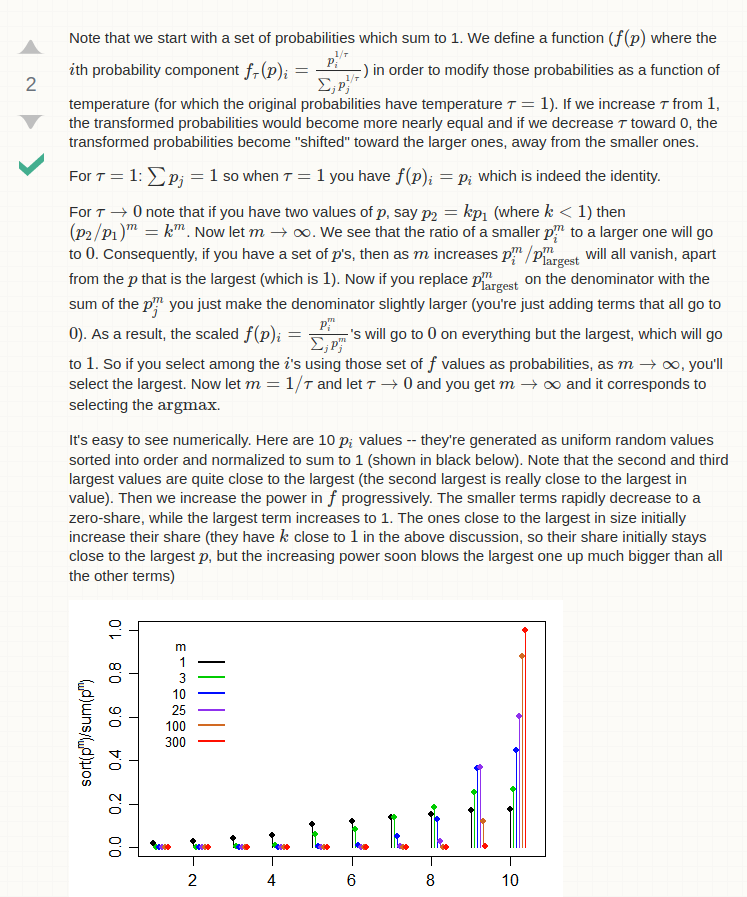

In [ ]:
for temp in [0.1, 0.3, 0.6, 0.9]:
    for sent_i in [5, 150, 350, 5000]:
        print(c2t.decode_sequence(X[sent_i].reshape(1,300), temp), "\n")
        print(Y_texts[sent_i], "\n")
        print("---")
    print("====")

In [ ]:
for temp in [0.1, 0.3, 0.6, 0.9]:
    print(temp)

In [ ]:
print(c2t.decode_sequence(X[1].reshape(1,300), 0.1), "\n")